## Tensorflow 의 DNN 을 사용한 총관중 예측 모델 
- 모델 자체는 복잡하지 않음
- Tensorflow 연습하기에 좋음. 여러 테크닉이 있음 
- 성능은 글쎄...

In [1]:
import os, sys, shutil
import pandas as pd
import numpy as np
import sklearn as sk 
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')
from sklearn import metrics  

import tensorflow as tf

plt.rcParams['font.family'] = 'NanumGothic'
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13 

import warnings
warnings.filterwarnings("ignore")

os_sep = os.sep 
home = os.path.expanduser("~")   # home = os.getenv("HOME")
np.random.seed(42)

sys.path.append(os.path.join(home, 'Google_Sync', 'Dev_Exercise', 'utils'))
from tf_utils import *  

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [2]:
sys.version, tf.__version__, sk.__version__ 

('3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:53:17) \n[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]',
 '1.11.0',
 '0.20.0')

In [3]:
# 첫째 열 '경기일자'를 datetime 타입으로 변환 
data = pd.read_excel('./train_data(2015-2018).xlsx', parse_dates=[0])  
data.tail()

,경기일자,KIA,LG,NC,SK,키움,두산,롯데,삼성,한화,...,전체_d2,전체_d3,전체_d4,전체_d5,전체_d6,전체_d7,전체_d8,전체_d9,전체_d10,전체_d11
256,2018-09-29,0,0,0,0,0,0,1,0,0,...,482,316,189,99,60,130,161,286,666,1052
257,2018-09-30,0,0,0,0,0,0,1,0,0,...,288,355,239,133,58,97,123,133,359,806
258,2018-10-06,0,0,0,0,0,0,0,1,0,...,85,125,129,154,182,138,148,231,336,581
259,2018-10-09,0,0,0,0,0,0,0,0,1,...,288,313,229,192,202,212,251,402,903,1714
260,2018-10-12,0,0,0,0,0,0,0,0,0,...,246,259,256,157,168,116,125,131,351,1128


### 탐색분석  : 

In [4]:
# data.describe(include="all")
data.info()
# data.경기일자.dtype   #  dtype('<M8[ns]') : datetime64[ns] 타입 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 83 columns):
경기일자      261 non-null datetime64[ns]
KIA       261 non-null int64
LG        261 non-null int64
NC        261 non-null int64
SK        261 non-null int64
키움        261 non-null int64
두산        261 non-null int64
롯데        261 non-null int64
삼성        261 non-null int64
한화        261 non-null int64
월         261 non-null int64
화         261 non-null int64
수         261 non-null int64
목         261 non-null int64
금         261 non-null int64
토         261 non-null int64
일         261 non-null int64
공휴일       261 non-null int64
1루        261 non-null int64
3루        261 non-null int64
외야        261 non-null int64
중앙        261 non-null int64
총관중수      261 non-null int64
1루_d0     261 non-null int64
1루_d1     261 non-null int64
1루_d2     261 non-null int64
1루_d3     261 non-null int64
1루_d4     261 non-null int64
1루_d5     261 non-null int64
1루_d6     261 non-null int64
1루_d7     261 no

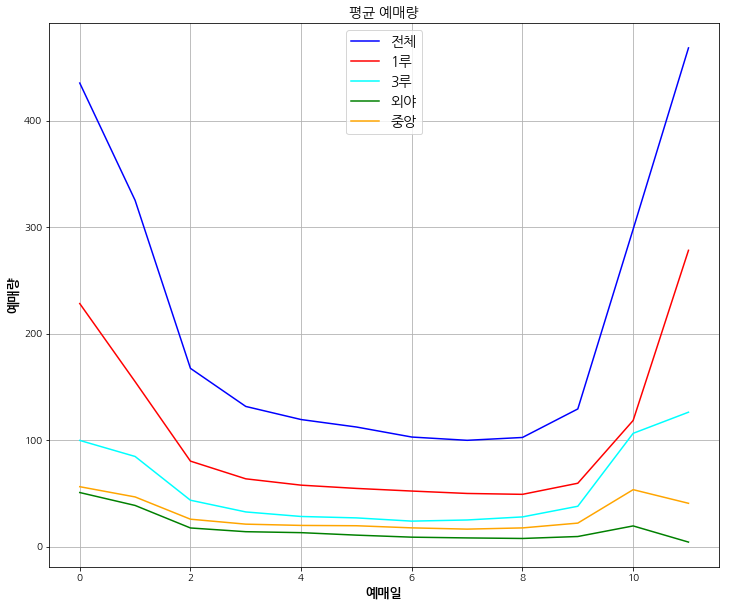

In [5]:
# np.mean(pd.concat( (train.총관중수, train.loc[:, '전체_d0':'전체_d11']), axis=1).values, axis=0)

plt.figure(figsize=(12,10))
plt.plot(np.mean( data.loc[:, '전체_d0':'전체_d11'].values, axis=0), c='b', label='전체')
plt.plot(np.mean( data.loc[:, '1루_d0':'1루_d11'].values, axis=0), c='r', label='1루')
plt.plot(np.mean( data.loc[:, '3루_d0':'3루_d11'].values, axis=0), c='cyan', label='3루')
plt.plot(np.mean( data.loc[:, '외야_d0':'외야_d11'].values, axis=0), c='g', label='외야')
plt.plot(np.mean( data.loc[:, '중앙_d0':'중앙_d11'].values, axis=0), c='orange', label='중앙')
plt.grid()
plt.legend(loc="best", fontsize=14)
plt.ylabel("예매량")
plt.xlabel("예매일")
plt.title("평균 예매량")
plt.show()

# 모델 만들기 - 총관중 예측
- Feature 만들기

In [6]:
X_base = data.loc[:,'KIA':'공휴일']        # 변하지 않는 X 
reserve = data.loc[:,'전체_d0':'전체_d11']    # 예매량: 입력과 target 역할 
reserve = reserve.iloc[:,::-1]        # 예매량: why reverse the order

X =  pd.concat([X_base, reserve], axis=1)   # 총관중 input features 
y_total = data['총관중수']            # 총관중 target/label 

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

### 모델들 만들기
- `_d11` : 예매 첫날 (경기전 12일) 예매량
- `_d0` : 예매 마지막날 (경기 전날) 예매량  
    
    
        
- 예매가 진행됨에 따라, 예매일 이후 날들에 대한 예매 예측 모델들을 만들어 dictionary 넣는다 
- 0'th day : 예매 시작 전,   1'th day : 예매 하루 후, ....  11'th day : 예매 11일 끝난 후 
- `y_model` : 총 관중 예측 모델
- `reserve_model` : 예매량 예측 모델    
   
   
- y_models : list of 12 models for y(총관중수) prediction 
  - input : X & progressive 예약 상황 
  - dict_y_models : dictionary pointing to the `y_models`
  - `y_model_0` : 예매 시작 전 총관중 예측 모델
  - `y_model_5` : 예매 5일 지난 시점 총관중 예측 모델   
  
     
- reserve_models  : list of models for reservation prediction for remaining days
  - input : X & progressive 예약 상황 
  - `dic_reserve_models` : dictionary pointing to the appropriate reserve models
  - `res_model_0_0` : reserve_model prediction done at 0'th day, predicting first day reservation
  - `res_model_3_7` : reserve_model prediction done at 3'th day(after 3'rd day rerservation is over), and                               predicting 8'th day reservation
  - `res_model_11_11` : 예매 시작 11일차 실적을 갖고 마지막 12일차 예매량 예측  

In [8]:
X.columns

Index(['KIA', 'LG', 'NC', 'SK', '키움', '두산', '롯데', '삼성', '한화', '월', '화', '수',
       '목', '금', '토', '일', '공휴일', '전체_d11', '전체_d10', '전체_d9', '전체_d8',
       '전체_d7', '전체_d6', '전체_d5', '전체_d4', '전체_d3', '전체_d2', '전체_d1', '전체_d0'],
      dtype='object')

In [9]:
data[186:191]

,경기일자,KIA,LG,NC,SK,키움,두산,롯데,삼성,한화,...,전체_d2,전체_d3,전체_d4,전체_d5,전체_d6,전체_d7,전체_d8,전체_d9,전체_d10,전체_d11
186,2017-10-01,1,0,0,0,0,0,0,0,0,...,281,321,213,256,208,231,248,440,1573,2607
187,2017-10-02,1,0,0,0,0,0,0,0,0,...,378,369,253,211,229,247,259,301,1092,1995
188,2017-10-03,1,0,0,0,0,0,0,0,0,...,511,390,398,356,278,254,190,246,784,1775
189,2018-03-30,0,0,0,0,0,1,0,0,0,...,175,144,187,109,115,138,131,168,595,1123
190,2018-03-31,0,0,0,0,0,1,0,0,0,...,376,382,325,392,305,226,187,324,904,1404


## Neural Net 총관중  모델 : 예매 시작 전 부터 예매 진행됨에 따른 ...
- training set : 2015~2017, 3년 경기 
- validation set :  2018 년 경기 


In [10]:
start_2018 = 189    # 2018 start index of X 
X_train, X_test = X[:start_2018], X[start_2018:]
y_train, y_test = y_total[:start_2018], y_total[start_2018:]   # y_total : 경기 당 총관중 

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((189, 29), (72, 29), (189,), (72,))

In [11]:
def NeuralNetRegressor(X_train, y_train, X_test, y_test, n_epochs=10000, model_id='total') :
    '''
    features : numpy float ndarray.  Design matrix 
    targets : numpy float vector
    model_id : integer or string 
    
    구조 : Tensorflow 사용 
    - 5개의 fully connected (dense) layer.  
    - 2개의 drop out layer
    - activation function : SELU
    - Cost(Loss) : MSE
    - Early stopping 조건 : 정해진 epoch 횟수에 Validation cost 감소가 없을 때 
    - 학습 모델 저장 : 지정된 './models_log ' directory 에 
    '''
    
    row_size, col_size = X_train.shape
    
    # ---------  Tensorflow Computational Graph Construction ---------
    
    reset_graph()
    
    he_init = tf.initializers.he_uniform()
    selu_init = tf.variance_scaling_initializer(scale=1.0, mode='fan_in')

    act_func = tf.nn.selu
    ker_init = selu_init

    X = tf.placeholder(tf.float32, shape=(None, col_size), name="X")
    y = tf.placeholder(tf.float32, shape=(None), name="y")
    training = tf.placeholder_with_default(False, shape=(), name='training')
    
    with tf.name_scope("hidden"):
        fc1 = tf.layers.dense(inputs=X, units=col_size*2, activation=act_func, 
                              kernel_initializer=ker_init, name="fc1")  
        # fc1_drop = tf.layers.dropout(fc1, 0.5, training=training)

        fc2 = tf.layers.dense(fc1, col_size*2, activation=act_func, 
                              kernel_initializer=ker_init, name="fc2") 
        fc2_drop = tf.layers.dropout(fc2, 0.25, training=training)
        
        fc3 = tf.layers.dense(fc2_drop, col_size, activation=act_func, 
                      kernel_initializer=ker_init, name="fc3") 

        fc4 = tf.layers.dense(fc3, col_size, activation=act_func,
                              kernel_initializer=ker_init, name="fc4")
        fc4_drop = tf.layers.dropout(fc4, 0.2, training=training)
        
        fc5 = tf.layers.dense(fc4_drop, int(col_size*0.5), activation=act_func,
                              kernel_initializer=ker_init, name="fc5")
    
    output = tf.layers.dense(fc5, 1, kernel_initializer=ker_init, name="output")
    
    with tf.name_scope("train"):
        loss = tf.reduce_mean(tf.square(output - y), name="loss")  # loss : MSE
        optimizer = tf.train.AdamOptimizer(0.0015)
        training_op = optimizer.minimize(loss) 
        
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    # -----  Computational Graph 완성 ---------
    
    best_loss = np.infty
    check_interval = 10
    checks_since_last_progress = 0
    max_checks_without_progress = 1000
    
    with tf.Session() as sess:
        init.run() 
        for epoch in range(n_epochs):
            # print("Epoch %d"%epoch)          
            sess.run(training_op, feed_dict={X:X_train, y:y_train, training:True} )
            
            if epoch % check_interval == 0 : 
                loss_value_train = sess.run(loss, feed_dict={X:X_train, y:y_train} )
                loss_value_validation = sess.run(loss, feed_dict={X:X_test, y:y_test} )
                print("Model_{}_{} \t loss_train = {} \t loss_valid = {} ".format(model_id,
                                    epoch, loss_value_train, loss_value_validation) )
                                                
                if loss_value_validation < best_loss : 
                    best_loss = loss_value_validation
                    checks_since_last_progress = 0
                    
                    y_model_key = 'y_model_' + str(model_id)
                    path = os.path.join('models_log', y_model_key)
                    save_path = saver.save(sess, path) 
                else :
                    checks_since_last_progress += 1   # increment at each check  
            
            if checks_since_last_progress > max_checks_without_progress: 
                print("Early stopping!") 
                break 
    for op in (X, y, loss, training_op, output):
        tf.add_to_collection("my_important_ops", op)
    
    return save_path 


In [12]:
X_train.columns

Index(['KIA', 'LG', 'NC', 'SK', '키움', '두산', '롯데', '삼성', '한화', '월', '화', '수',
       '목', '금', '토', '일', '공휴일', '전체_d11', '전체_d10', '전체_d9', '전체_d8',
       '전체_d7', '전체_d6', '전체_d5', '전체_d4', '전체_d3', '전체_d2', '전체_d1', '전체_d0'],
      dtype='object')

#### 예매 전 부터 시작해 예매일 마다 총관중 예측 :

In [13]:
%%time
res_start = 17
dict_y_models_train = {}              # dict of models for y(총관중수) prediction 
# dict_reserve_models_train = {}        # dict of models for reservation prediction 

for day in range(0, 12):   
    
    # Predict y_total(총관중수) as reservation progresses. Note that features differ 
    X_train_values = np.array(X_train.iloc[:, 0:res_start+day].values, dtype=np.float32)
    y_train_values = np.array(y_train.values, dtype=np.float32)
    
    X_test_values = np.array(X_test.iloc[:, 0:res_start+day].values, dtype=np.float32)
    y_test_values = np.array(y_test.values, dtype=np.float32)
                              
    y_model_path = NeuralNetRegressor(X_train_values, y_train_values, 
                                      X_test_values, y_test_values,
                                      n_epochs=100000, model_id=day)
    
    y_model_key = 'y_model_' + str(day)   # y_model_n : n'th day prediction of y
    dict_y_models_train[y_model_key] = y_model_path     


Model_0_0 	 loss_train = 119493408.0 	 loss_valid = 104556416.0 
Model_0_10 	 loss_train = 119429848.0 	 loss_valid = 104495392.0 
Model_0_20 	 loss_train = 119339768.0 	 loss_valid = 104410232.0 
Model_0_30 	 loss_train = 119212832.0 	 loss_valid = 104291352.0 
Model_0_40 	 loss_train = 119027664.0 	 loss_valid = 104117312.0 
Model_0_50 	 loss_train = 118725408.0 	 loss_valid = 103832760.0 
Model_0_60 	 loss_train = 118206616.0 	 loss_valid = 103343896.0 
Model_0_70 	 loss_train = 117294912.0 	 loss_valid = 102484144.0 
Model_0_80 	 loss_train = 115694320.0 	 loss_valid = 100974128.0 
Model_0_90 	 loss_train = 112954688.0 	 loss_valid = 98389312.0 
Model_0_100 	 loss_train = 108414176.0 	 loss_valid = 94111024.0 
Model_0_110 	 loss_train = 101224544.0 	 loss_valid = 87360856.0 
Model_0_120 	 loss_train = 90460336.0 	 loss_valid = 77324576.0 
Model_0_130 	 loss_train = 75704744.0 	 loss_valid = 63742680.0 
Model_0_140 	 loss_train = 57913120.0 	 loss_valid = 47781536.0 
Model_0_150 	 l

Model_0_1310 	 loss_train = 28231138.0 	 loss_valid = 25303744.0 
Model_0_1320 	 loss_train = 28116850.0 	 loss_valid = 25367646.0 
Model_0_1330 	 loss_train = 28130554.0 	 loss_valid = 25355682.0 
Model_0_1340 	 loss_train = 28187086.0 	 loss_valid = 25319902.0 
Model_0_1350 	 loss_train = 28162398.0 	 loss_valid = 25332678.0 
Model_0_1360 	 loss_train = 28113386.0 	 loss_valid = 25367356.0 
Model_0_1370 	 loss_train = 28163414.0 	 loss_valid = 25331320.0 
Model_0_1380 	 loss_train = 28159940.0 	 loss_valid = 25332728.0 
Model_0_1390 	 loss_train = 28203946.0 	 loss_valid = 25309216.0 
Model_0_1400 	 loss_train = 28248984.0 	 loss_valid = 25292480.0 
Model_0_1410 	 loss_train = 28103902.0 	 loss_valid = 25370296.0 
Model_0_1420 	 loss_train = 28129440.0 	 loss_valid = 25348438.0 
Model_0_1430 	 loss_train = 28135062.0 	 loss_valid = 25343756.0 
Model_0_1440 	 loss_train = 28166166.0 	 loss_valid = 25323792.0 
Model_0_1450 	 loss_train = 28122360.0 	 loss_valid = 25353130.0 
Model_0_14

Model_0_2640 	 loss_train = 28083922.0 	 loss_valid = 25371706.0 
Model_0_2650 	 loss_train = 28157966.0 	 loss_valid = 25312304.0 
Model_0_2660 	 loss_train = 28068728.0 	 loss_valid = 25390084.0 
Model_0_2670 	 loss_train = 28051248.0 	 loss_valid = 25415030.0 
Model_0_2680 	 loss_train = 28267796.0 	 loss_valid = 25270166.0 
Model_0_2690 	 loss_train = 28089634.0 	 loss_valid = 25365304.0 
Model_0_2700 	 loss_train = 28035178.0 	 loss_valid = 25444326.0 
Model_0_2710 	 loss_train = 28136720.0 	 loss_valid = 25325534.0 
Model_0_2720 	 loss_train = 28078396.0 	 loss_valid = 25378084.0 
Model_0_2730 	 loss_train = 28119406.0 	 loss_valid = 25338286.0 
Model_0_2740 	 loss_train = 28109682.0 	 loss_valid = 25346542.0 
Model_0_2750 	 loss_train = 28073266.0 	 loss_valid = 25384720.0 
Model_0_2760 	 loss_train = 28079166.0 	 loss_valid = 25377264.0 
Model_0_2770 	 loss_train = 28076656.0 	 loss_valid = 25380384.0 
Model_0_2780 	 loss_train = 28066390.0 	 loss_valid = 25393876.0 
Model_0_27

Model_0_3980 	 loss_train = 28064272.0 	 loss_valid = 25394388.0 
Model_0_3990 	 loss_train = 28081390.0 	 loss_valid = 25373008.0 
Model_0_4000 	 loss_train = 28165238.0 	 loss_valid = 25306244.0 
Model_0_4010 	 loss_train = 28108028.0 	 loss_valid = 25346188.0 
Model_0_4020 	 loss_train = 28037930.0 	 loss_valid = 25437240.0 
Model_0_4030 	 loss_train = 28083386.0 	 loss_valid = 25370980.0 
Model_0_4040 	 loss_train = 28051638.0 	 loss_valid = 25413246.0 
Model_0_4050 	 loss_train = 28083712.0 	 loss_valid = 25370826.0 
Model_0_4060 	 loss_train = 28067824.0 	 loss_valid = 25390770.0 
Model_0_4070 	 loss_train = 28067036.0 	 loss_valid = 25392048.0 
Model_0_4080 	 loss_train = 28123514.0 	 loss_valid = 25334382.0 
Model_0_4090 	 loss_train = 28058896.0 	 loss_valid = 25403050.0 
Model_0_4100 	 loss_train = 28099376.0 	 loss_valid = 25354914.0 
Model_0_4110 	 loss_train = 28141578.0 	 loss_valid = 25321024.0 
Model_0_4120 	 loss_train = 28025636.0 	 loss_valid = 25464362.0 
Model_0_41

Model_0_5320 	 loss_train = 28086424.0 	 loss_valid = 25369808.0 
Model_0_5330 	 loss_train = 28006750.0 	 loss_valid = 25521038.0 
Model_0_5340 	 loss_train = 28114142.0 	 loss_valid = 25344268.0 
Model_0_5350 	 loss_train = 28030778.0 	 loss_valid = 25455012.0 
Model_0_5360 	 loss_train = 28116090.0 	 loss_valid = 25345214.0 
Model_0_5370 	 loss_train = 28038466.0 	 loss_valid = 25439360.0 
Model_0_5380 	 loss_train = 28082458.0 	 loss_valid = 25376494.0 
Model_0_5390 	 loss_train = 28096398.0 	 loss_valid = 25361816.0 
Model_0_5400 	 loss_train = 28044508.0 	 loss_valid = 25429438.0 
Model_0_5410 	 loss_train = 28055400.0 	 loss_valid = 25414444.0 
Model_0_5420 	 loss_train = 28112144.0 	 loss_valid = 25353520.0 
Model_0_5430 	 loss_train = 28086736.0 	 loss_valid = 25379316.0 
Model_0_5440 	 loss_train = 28070716.0 	 loss_valid = 25397852.0 
Model_0_5450 	 loss_train = 28110470.0 	 loss_valid = 25351426.0 
Model_0_5460 	 loss_train = 28070874.0 	 loss_valid = 25391454.0 
Model_0_54

Model_0_6650 	 loss_train = 28013644.0 	 loss_valid = 25503084.0 
Model_0_6660 	 loss_train = 28133642.0 	 loss_valid = 25334238.0 
Model_0_6670 	 loss_train = 28057386.0 	 loss_valid = 25416082.0 
Model_0_6680 	 loss_train = 28079904.0 	 loss_valid = 25387728.0 
Model_0_6690 	 loss_train = 28086636.0 	 loss_valid = 25378192.0 
Model_0_6700 	 loss_train = 28085916.0 	 loss_valid = 25377726.0 
Model_0_6710 	 loss_train = 28039366.0 	 loss_valid = 25445906.0 
Model_0_6720 	 loss_train = 28062474.0 	 loss_valid = 25404208.0 
Model_0_6730 	 loss_train = 28062320.0 	 loss_valid = 25401838.0 
Model_0_6740 	 loss_train = 28002770.0 	 loss_valid = 25544038.0 
Model_0_6750 	 loss_train = 28120544.0 	 loss_valid = 25340756.0 
Model_0_6760 	 loss_train = 28060706.0 	 loss_valid = 25406116.0 
Model_0_6770 	 loss_train = 28052922.0 	 loss_valid = 25418628.0 
Model_0_6780 	 loss_train = 28012806.0 	 loss_valid = 25509448.0 
Model_0_6790 	 loss_train = 28093320.0 	 loss_valid = 25363266.0 
Model_0_68

Model_0_7970 	 loss_train = 28073136.0 	 loss_valid = 25384602.0 
Model_0_7980 	 loss_train = 28013224.0 	 loss_valid = 25502770.0 
Model_0_7990 	 loss_train = 28038550.0 	 loss_valid = 25441482.0 
Model_0_8000 	 loss_train = 28022570.0 	 loss_valid = 25478076.0 
Model_0_8010 	 loss_train = 28031006.0 	 loss_valid = 25457746.0 
Model_0_8020 	 loss_train = 28089354.0 	 loss_valid = 25368964.0 
Model_0_8030 	 loss_train = 28027332.0 	 loss_valid = 25466494.0 
Model_0_8040 	 loss_train = 28050300.0 	 loss_valid = 25419092.0 
Model_0_8050 	 loss_train = 28041866.0 	 loss_valid = 25432746.0 
Model_0_8060 	 loss_train = 28037152.0 	 loss_valid = 25440630.0 
Model_0_8070 	 loss_train = 28054342.0 	 loss_valid = 25410136.0 
Model_0_8080 	 loss_train = 28028294.0 	 loss_valid = 25459828.0 
Model_0_8090 	 loss_train = 28020860.0 	 loss_valid = 25480106.0 
Model_0_8100 	 loss_train = 28048898.0 	 loss_valid = 25419304.0 
Model_0_8110 	 loss_train = 28064334.0 	 loss_valid = 25395242.0 
Model_0_81

Model_0_9230 	 loss_train = 27998500.0 	 loss_valid = 25565308.0 
Model_0_9240 	 loss_train = 28025662.0 	 loss_valid = 25469798.0 
Model_0_9250 	 loss_train = 28034228.0 	 loss_valid = 25450402.0 
Model_0_9260 	 loss_train = 28000694.0 	 loss_valid = 25553480.0 
Model_0_9270 	 loss_train = 28079164.0 	 loss_valid = 25379922.0 
Model_0_9280 	 loss_train = 28004900.0 	 loss_valid = 25535232.0 
Model_0_9290 	 loss_train = 28056820.0 	 loss_valid = 25410528.0 
Model_0_9300 	 loss_train = 28022676.0 	 loss_valid = 25477556.0 
Model_0_9310 	 loss_train = 28034500.0 	 loss_valid = 25450364.0 
Model_0_9320 	 loss_train = 28020574.0 	 loss_valid = 25484056.0 
Model_0_9330 	 loss_train = 28019632.0 	 loss_valid = 25488116.0 
Model_0_9340 	 loss_train = 28008682.0 	 loss_valid = 25524058.0 
Model_0_9350 	 loss_train = 28007454.0 	 loss_valid = 25527406.0 
Model_0_9360 	 loss_train = 28044036.0 	 loss_valid = 25433168.0 
Model_0_9370 	 loss_train = 28031464.0 	 loss_valid = 25457930.0 
Model_0_93

Model_0_10550 	 loss_train = 28001020.0 	 loss_valid = 25552784.0 
Model_0_10560 	 loss_train = 28033626.0 	 loss_valid = 25451660.0 
Model_0_10570 	 loss_train = 28017642.0 	 loss_valid = 25490966.0 
Model_0_10580 	 loss_train = 28016098.0 	 loss_valid = 25495314.0 
Model_0_10590 	 loss_train = 28024974.0 	 loss_valid = 25471122.0 
Model_0_10600 	 loss_train = 27996750.0 	 loss_valid = 25576716.0 
Model_0_10610 	 loss_train = 28006860.0 	 loss_valid = 25526652.0 
Model_0_10620 	 loss_train = 28045154.0 	 loss_valid = 25428856.0 
Model_0_10630 	 loss_train = 28026896.0 	 loss_valid = 25466330.0 
Model_0_10640 	 loss_train = 28012418.0 	 loss_valid = 25507050.0 
Model_0_10650 	 loss_train = 28027804.0 	 loss_valid = 25465024.0 
Model_0_10660 	 loss_train = 28001490.0 	 loss_valid = 25550950.0 
Model_0_10670 	 loss_train = 28025448.0 	 loss_valid = 25471124.0 
Model_0_10680 	 loss_train = 28027220.0 	 loss_valid = 25467060.0 
Model_0_10690 	 loss_train = 28003432.0 	 loss_valid = 2554192

Model_0_11890 	 loss_train = 28004972.0 	 loss_valid = 25532502.0 
Model_0_11900 	 loss_train = 28008226.0 	 loss_valid = 25519636.0 
Model_0_11910 	 loss_train = 28021176.0 	 loss_valid = 25479028.0 
Model_0_11920 	 loss_train = 28039068.0 	 loss_valid = 25438428.0 
Model_0_11930 	 loss_train = 28012778.0 	 loss_valid = 25503706.0 
Model_0_11940 	 loss_train = 28005210.0 	 loss_valid = 25531406.0 
Model_0_11950 	 loss_train = 28011016.0 	 loss_valid = 25509572.0 
Model_0_11960 	 loss_train = 28004012.0 	 loss_valid = 25536490.0 
Model_0_11970 	 loss_train = 28017580.0 	 loss_valid = 25488940.0 
Model_0_11980 	 loss_train = 28013162.0 	 loss_valid = 25502422.0 
Model_0_11990 	 loss_train = 28010374.0 	 loss_valid = 25511786.0 
Model_0_12000 	 loss_train = 28002778.0 	 loss_valid = 25541998.0 
Model_0_12010 	 loss_train = 28005112.0 	 loss_valid = 25531806.0 
Model_0_12020 	 loss_train = 28014528.0 	 loss_valid = 25498106.0 
Model_0_12030 	 loss_train = 28008254.0 	 loss_valid = 2551945

Model_1_0 	 loss_train = 119448136.0 	 loss_valid = 104476344.0 
Model_1_10 	 loss_train = 118586720.0 	 loss_valid = 103244976.0 
Model_1_20 	 loss_train = 116971320.0 	 loss_valid = 100859408.0 
Model_1_30 	 loss_train = 113551576.0 	 loss_valid = 95848648.0 
Model_1_40 	 loss_train = 106943312.0 	 loss_valid = 86429776.0 
Model_1_50 	 loss_train = 95261096.0 	 loss_valid = 71125008.0 
Model_1_60 	 loss_train = 80854528.0 	 loss_valid = 58447044.0 
Model_1_70 	 loss_train = 77299216.0 	 loss_valid = 70882240.0 
Model_1_80 	 loss_train = 76516440.0 	 loss_valid = 63360476.0 
Model_1_90 	 loss_train = 77004168.0 	 loss_valid = 59353828.0 
Model_1_100 	 loss_train = 76295232.0 	 loss_valid = 60153604.0 
Model_1_110 	 loss_train = 75474592.0 	 loss_valid = 62876792.0 
Model_1_120 	 loss_train = 75232736.0 	 loss_valid = 61417496.0 
Model_1_130 	 loss_train = 74978832.0 	 loss_valid = 60259876.0 
Model_1_140 	 loss_train = 74340672.0 	 loss_valid = 61155820.0 
Model_1_150 	 loss_train = 7

Model_1_1270 	 loss_train = 28286108.0 	 loss_valid = 25274406.0 
Model_1_1280 	 loss_train = 28182934.0 	 loss_valid = 25303390.0 
Model_1_1290 	 loss_train = 28137058.0 	 loss_valid = 25323802.0 
Model_1_1300 	 loss_train = 28143722.0 	 loss_valid = 25333858.0 
Model_1_1310 	 loss_train = 28179102.0 	 loss_valid = 25324390.0 
Model_1_1320 	 loss_train = 28164038.0 	 loss_valid = 25307348.0 
Model_1_1330 	 loss_train = 28185240.0 	 loss_valid = 25291870.0 
Model_1_1340 	 loss_train = 28201756.0 	 loss_valid = 25286906.0 
Model_1_1350 	 loss_train = 28175956.0 	 loss_valid = 25319364.0 
Model_1_1360 	 loss_train = 28120990.0 	 loss_valid = 25358790.0 
Model_1_1370 	 loss_train = 28281096.0 	 loss_valid = 25269576.0 
Model_1_1380 	 loss_train = 28453820.0 	 loss_valid = 25286070.0 
Model_1_1390 	 loss_train = 28173766.0 	 loss_valid = 25354878.0 
Model_1_1400 	 loss_train = 28167006.0 	 loss_valid = 25430118.0 
Model_1_1410 	 loss_train = 28299858.0 	 loss_valid = 25268116.0 
Model_1_14

Model_1_2560 	 loss_train = 28165782.0 	 loss_valid = 25304698.0 
Model_1_2570 	 loss_train = 28288878.0 	 loss_valid = 25264976.0 
Model_1_2580 	 loss_train = 28316806.0 	 loss_valid = 25254588.0 
Model_1_2590 	 loss_train = 28098874.0 	 loss_valid = 25367556.0 
Model_1_2600 	 loss_train = 28200058.0 	 loss_valid = 25283260.0 
Model_1_2610 	 loss_train = 28090698.0 	 loss_valid = 25360522.0 
Model_1_2620 	 loss_train = 28218600.0 	 loss_valid = 25298090.0 
Model_1_2630 	 loss_train = 28139484.0 	 loss_valid = 25392346.0 
Model_1_2640 	 loss_train = 28219922.0 	 loss_valid = 25277136.0 
Model_1_2650 	 loss_train = 28070278.0 	 loss_valid = 25496316.0 
Model_1_2660 	 loss_train = 28252498.0 	 loss_valid = 25276240.0 
Model_1_2670 	 loss_train = 28112510.0 	 loss_valid = 25331248.0 
Model_1_2680 	 loss_train = 28084366.0 	 loss_valid = 25429844.0 
Model_1_2690 	 loss_train = 28211878.0 	 loss_valid = 25284222.0 
Model_1_2700 	 loss_train = 28162560.0 	 loss_valid = 25317760.0 
Model_1_27

Model_1_3820 	 loss_train = 28131312.0 	 loss_valid = 25315340.0 
Model_1_3830 	 loss_train = 28092826.0 	 loss_valid = 25369826.0 
Model_1_3840 	 loss_train = 28177008.0 	 loss_valid = 25289810.0 
Model_1_3850 	 loss_train = 28239046.0 	 loss_valid = 25279220.0 
Model_1_3860 	 loss_train = 28067246.0 	 loss_valid = 25376282.0 
Model_1_3870 	 loss_train = 28123206.0 	 loss_valid = 25324668.0 
Model_1_3880 	 loss_train = 28132640.0 	 loss_valid = 25334664.0 
Model_1_3890 	 loss_train = 28127028.0 	 loss_valid = 25327734.0 
Model_1_3900 	 loss_train = 28122356.0 	 loss_valid = 25324256.0 
Model_1_3910 	 loss_train = 28151240.0 	 loss_valid = 25307746.0 
Model_1_3920 	 loss_train = 28092886.0 	 loss_valid = 25367646.0 
Model_1_3930 	 loss_train = 28297642.0 	 loss_valid = 25256058.0 
Model_1_3940 	 loss_train = 28042238.0 	 loss_valid = 25461792.0 
Model_1_3950 	 loss_train = 28343178.0 	 loss_valid = 25262394.0 
Model_1_3960 	 loss_train = 28008652.0 	 loss_valid = 25608366.0 
Model_1_39

Model_1_5170 	 loss_train = 28145492.0 	 loss_valid = 25311720.0 
Model_1_5180 	 loss_train = 28072558.0 	 loss_valid = 25403124.0 
Model_1_5190 	 loss_train = 28039126.0 	 loss_valid = 25462706.0 
Model_1_5200 	 loss_train = 28275028.0 	 loss_valid = 25261394.0 
Model_1_5210 	 loss_train = 28010854.0 	 loss_valid = 25542946.0 
Model_1_5220 	 loss_train = 28166284.0 	 loss_valid = 25302326.0 
Model_1_5230 	 loss_train = 28083952.0 	 loss_valid = 25362780.0 
Model_1_5240 	 loss_train = 28083366.0 	 loss_valid = 25359120.0 
Model_1_5250 	 loss_train = 28080144.0 	 loss_valid = 25366842.0 
Model_1_5260 	 loss_train = 28056746.0 	 loss_valid = 25412970.0 
Model_1_5270 	 loss_train = 28208124.0 	 loss_valid = 25280260.0 
Model_1_5280 	 loss_train = 28059584.0 	 loss_valid = 25396242.0 
Model_1_5290 	 loss_train = 28157864.0 	 loss_valid = 25303182.0 
Model_1_5300 	 loss_train = 28093040.0 	 loss_valid = 25350704.0 
Model_1_5310 	 loss_train = 28147920.0 	 loss_valid = 25316954.0 
Model_1_53

Model_1_6420 	 loss_train = 28143836.0 	 loss_valid = 25322016.0 
Model_1_6430 	 loss_train = 28116402.0 	 loss_valid = 25336560.0 
Model_1_6440 	 loss_train = 28083064.0 	 loss_valid = 25366502.0 
Model_1_6450 	 loss_train = 28198060.0 	 loss_valid = 25283448.0 
Model_1_6460 	 loss_train = 28110348.0 	 loss_valid = 25337832.0 
Model_1_6470 	 loss_train = 28082870.0 	 loss_valid = 25375624.0 
Model_1_6480 	 loss_train = 28070412.0 	 loss_valid = 25392700.0 
Model_1_6490 	 loss_train = 28213140.0 	 loss_valid = 25279642.0 
Model_1_6500 	 loss_train = 28055246.0 	 loss_valid = 25415782.0 
Model_1_6510 	 loss_train = 28067432.0 	 loss_valid = 25390408.0 
Model_1_6520 	 loss_train = 28145038.0 	 loss_valid = 25314364.0 
Model_1_6530 	 loss_train = 28139522.0 	 loss_valid = 25316262.0 
Model_1_6540 	 loss_train = 28090706.0 	 loss_valid = 25363286.0 
Model_1_6550 	 loss_train = 28135422.0 	 loss_valid = 25324522.0 
Model_1_6560 	 loss_train = 28120644.0 	 loss_valid = 25343142.0 
Model_1_65

Model_1_7740 	 loss_train = 28061772.0 	 loss_valid = 25396524.0 
Model_1_7750 	 loss_train = 28059032.0 	 loss_valid = 25401234.0 
Model_1_7760 	 loss_train = 28047586.0 	 loss_valid = 25415724.0 
Model_1_7770 	 loss_train = 28082442.0 	 loss_valid = 25360174.0 
Model_1_7780 	 loss_train = 28026258.0 	 loss_valid = 25463420.0 
Model_1_7790 	 loss_train = 28062768.0 	 loss_valid = 25396054.0 
Model_1_7800 	 loss_train = 28041578.0 	 loss_valid = 25428590.0 
Model_1_7810 	 loss_train = 28055582.0 	 loss_valid = 25405406.0 
Model_1_7820 	 loss_train = 28070550.0 	 loss_valid = 25391056.0 
Model_1_7830 	 loss_train = 28021308.0 	 loss_valid = 25473810.0 
Model_1_7840 	 loss_train = 28067828.0 	 loss_valid = 25384656.0 
Model_1_7850 	 loss_train = 28074720.0 	 loss_valid = 25376238.0 
Model_1_7860 	 loss_train = 28043476.0 	 loss_valid = 25423288.0 
Model_1_7870 	 loss_train = 28029528.0 	 loss_valid = 25455034.0 
Model_1_7880 	 loss_train = 28055192.0 	 loss_valid = 25407222.0 
Model_1_78

Model_1_9090 	 loss_train = 28009160.0 	 loss_valid = 25518080.0 
Model_1_9100 	 loss_train = 28032540.0 	 loss_valid = 25450174.0 
Model_1_9110 	 loss_train = 28032082.0 	 loss_valid = 25448900.0 
Model_1_9120 	 loss_train = 28011350.0 	 loss_valid = 25505908.0 
Model_1_9130 	 loss_train = 28066280.0 	 loss_valid = 25392284.0 
Model_1_9140 	 loss_train = 28018750.0 	 loss_valid = 25485800.0 
Model_1_9150 	 loss_train = 28002800.0 	 loss_valid = 25545446.0 
Model_1_9160 	 loss_train = 28022702.0 	 loss_valid = 25478118.0 
Model_1_9170 	 loss_train = 28015658.0 	 loss_valid = 25498012.0 
Model_1_9180 	 loss_train = 28024224.0 	 loss_valid = 25475040.0 
Model_1_9190 	 loss_train = 28006014.0 	 loss_valid = 25530104.0 
Model_1_9200 	 loss_train = 28014696.0 	 loss_valid = 25499110.0 
Model_1_9210 	 loss_train = 28014318.0 	 loss_valid = 25502536.0 
Model_1_9220 	 loss_train = 28011682.0 	 loss_valid = 25511756.0 
Model_1_9230 	 loss_train = 28048872.0 	 loss_valid = 25421908.0 
Model_1_92

Model_1_10430 	 loss_train = 28024852.0 	 loss_valid = 25465572.0 
Model_1_10440 	 loss_train = 28010538.0 	 loss_valid = 25508498.0 
Model_1_10450 	 loss_train = 27995960.0 	 loss_valid = 25581300.0 
Model_1_10460 	 loss_train = 28021172.0 	 loss_valid = 25482018.0 
Model_1_10470 	 loss_train = 28004492.0 	 loss_valid = 25538258.0 
Model_1_10480 	 loss_train = 28012006.0 	 loss_valid = 25508168.0 
Model_1_10490 	 loss_train = 28011786.0 	 loss_valid = 25509092.0 
Model_1_10500 	 loss_train = 28023180.0 	 loss_valid = 25475950.0 
Model_1_10510 	 loss_train = 28008754.0 	 loss_valid = 25518990.0 
Model_1_10520 	 loss_train = 28000602.0 	 loss_valid = 25555882.0 
Model_1_10530 	 loss_train = 28012572.0 	 loss_valid = 25507754.0 
Model_1_10540 	 loss_train = 28001048.0 	 loss_valid = 25554164.0 
Model_1_10550 	 loss_train = 28021886.0 	 loss_valid = 25480130.0 
Model_1_10560 	 loss_train = 27996904.0 	 loss_valid = 25578002.0 
Model_1_10570 	 loss_train = 28006136.0 	 loss_valid = 2553011

Model_1_11690 	 loss_train = 28007384.0 	 loss_valid = 25522158.0 
Model_1_11700 	 loss_train = 28015708.0 	 loss_valid = 25494322.0 
Model_1_11710 	 loss_train = 27998162.0 	 loss_valid = 25568490.0 
Model_1_11720 	 loss_train = 27997476.0 	 loss_valid = 25573566.0 
Model_1_11730 	 loss_train = 28017122.0 	 loss_valid = 25491888.0 
Model_1_11740 	 loss_train = 28007096.0 	 loss_valid = 25525580.0 
Model_1_11750 	 loss_train = 27998232.0 	 loss_valid = 25564020.0 
Model_1_11760 	 loss_train = 28019770.0 	 loss_valid = 25479012.0 
Model_1_11770 	 loss_train = 28011584.0 	 loss_valid = 25503864.0 
Model_1_11780 	 loss_train = 28007726.0 	 loss_valid = 25518776.0 
Model_1_11790 	 loss_train = 28001204.0 	 loss_valid = 25547474.0 
Model_1_11800 	 loss_train = 27992422.0 	 loss_valid = 25608204.0 
Model_1_11810 	 loss_train = 28020050.0 	 loss_valid = 25484930.0 
Model_1_11820 	 loss_train = 28027004.0 	 loss_valid = 25467814.0 
Model_1_11830 	 loss_train = 27995988.0 	 loss_valid = 2558432

Model_1_13020 	 loss_train = 28011174.0 	 loss_valid = 25511524.0 
Model_1_13030 	 loss_train = 27996394.0 	 loss_valid = 25580644.0 
Model_1_13040 	 loss_train = 28000062.0 	 loss_valid = 25560874.0 
Model_1_13050 	 loss_train = 28002930.0 	 loss_valid = 25546138.0 
Model_1_13060 	 loss_train = 28008658.0 	 loss_valid = 25521948.0 
Model_1_13070 	 loss_train = 28004678.0 	 loss_valid = 25536790.0 
Model_1_13080 	 loss_train = 28000210.0 	 loss_valid = 25555524.0 
Model_1_13090 	 loss_train = 28002282.0 	 loss_valid = 25544296.0 
Model_1_13100 	 loss_train = 27998398.0 	 loss_valid = 25564064.0 
Model_1_13110 	 loss_train = 28011092.0 	 loss_valid = 25508444.0 
Model_1_13120 	 loss_train = 27999652.0 	 loss_valid = 25556936.0 
Model_1_13130 	 loss_train = 27998768.0 	 loss_valid = 25561598.0 
Model_1_13140 	 loss_train = 28011302.0 	 loss_valid = 25507550.0 
Early stopping!
Model_2_0 	 loss_train = 119565416.0 	 loss_valid = 104564104.0 
Model_2_10 	 loss_train = 117983104.0 	 loss_val

Model_2_1190 	 loss_train = 28321328.0 	 loss_valid = 25390528.0 
Model_2_1200 	 loss_train = 28372126.0 	 loss_valid = 25310408.0 
Model_2_1210 	 loss_train = 28654298.0 	 loss_valid = 25367782.0 
Model_2_1220 	 loss_train = 28546886.0 	 loss_valid = 25295442.0 
Model_2_1230 	 loss_train = 28331992.0 	 loss_valid = 25300566.0 
Model_2_1240 	 loss_train = 28413372.0 	 loss_valid = 25289698.0 
Model_2_1250 	 loss_train = 28572158.0 	 loss_valid = 25318042.0 
Model_2_1260 	 loss_train = 28336486.0 	 loss_valid = 25337848.0 
Model_2_1270 	 loss_train = 28351702.0 	 loss_valid = 25313194.0 
Model_2_1280 	 loss_train = 28472030.0 	 loss_valid = 25325558.0 
Model_2_1290 	 loss_train = 28654916.0 	 loss_valid = 25310558.0 
Model_2_1300 	 loss_train = 28464074.0 	 loss_valid = 25289348.0 
Model_2_1310 	 loss_train = 28206236.0 	 loss_valid = 25390076.0 
Model_2_1320 	 loss_train = 28245578.0 	 loss_valid = 25393296.0 
Model_2_1330 	 loss_train = 28965348.0 	 loss_valid = 25509566.0 
Model_2_13

Model_2_2440 	 loss_train = 32601386.0 	 loss_valid = 27552408.0 
Model_2_2450 	 loss_train = 32414934.0 	 loss_valid = 27524144.0 
Model_2_2460 	 loss_train = 32281128.0 	 loss_valid = 27415160.0 
Model_2_2470 	 loss_train = 32494988.0 	 loss_valid = 27433656.0 
Model_2_2480 	 loss_train = 32171324.0 	 loss_valid = 27222622.0 
Model_2_2490 	 loss_train = 32568448.0 	 loss_valid = 27572168.0 
Model_2_2500 	 loss_train = 33139722.0 	 loss_valid = 28038656.0 
Model_2_2510 	 loss_train = 32584784.0 	 loss_valid = 27537594.0 
Model_2_2520 	 loss_train = 32604224.0 	 loss_valid = 27671338.0 
Model_2_2530 	 loss_train = 32458104.0 	 loss_valid = 27448212.0 
Model_2_2540 	 loss_train = 33681148.0 	 loss_valid = 28711440.0 
Model_2_2550 	 loss_train = 33339366.0 	 loss_valid = 28362506.0 
Model_2_2560 	 loss_train = 32769376.0 	 loss_valid = 27835888.0 
Model_2_2570 	 loss_train = 32848304.0 	 loss_valid = 27746636.0 
Model_2_2580 	 loss_train = 33020076.0 	 loss_valid = 27969758.0 
Model_2_25

Model_2_3810 	 loss_train = 34308168.0 	 loss_valid = 28924080.0 
Model_2_3820 	 loss_train = 34008880.0 	 loss_valid = 28864534.0 
Model_2_3830 	 loss_train = 33749068.0 	 loss_valid = 28397000.0 
Model_2_3840 	 loss_train = 33817492.0 	 loss_valid = 28496258.0 
Model_2_3850 	 loss_train = 33968304.0 	 loss_valid = 28747388.0 
Model_2_3860 	 loss_train = 34546172.0 	 loss_valid = 29184854.0 
Model_2_3870 	 loss_train = 33993172.0 	 loss_valid = 28589820.0 
Model_2_3880 	 loss_train = 33558232.0 	 loss_valid = 28338208.0 
Model_2_3890 	 loss_train = 34206288.0 	 loss_valid = 28773900.0 
Model_2_3900 	 loss_train = 33944776.0 	 loss_valid = 28566920.0 
Model_2_3910 	 loss_train = 33244628.0 	 loss_valid = 28052126.0 
Model_2_3920 	 loss_train = 33867564.0 	 loss_valid = 28517110.0 
Model_2_3930 	 loss_train = 33905724.0 	 loss_valid = 28542296.0 
Model_2_3940 	 loss_train = 34152952.0 	 loss_valid = 28843432.0 
Model_2_3950 	 loss_train = 34162676.0 	 loss_valid = 28806628.0 
Model_2_39

Model_2_5070 	 loss_train = 35522168.0 	 loss_valid = 29932000.0 
Model_2_5080 	 loss_train = 34897408.0 	 loss_valid = 29087726.0 
Model_2_5090 	 loss_train = 34269252.0 	 loss_valid = 28930872.0 
Model_2_5100 	 loss_train = 34492820.0 	 loss_valid = 28784608.0 
Model_2_5110 	 loss_train = 34679944.0 	 loss_valid = 29104046.0 
Model_2_5120 	 loss_train = 35537144.0 	 loss_valid = 29711146.0 
Model_2_5130 	 loss_train = 35128192.0 	 loss_valid = 29476280.0 
Model_2_5140 	 loss_train = 34845544.0 	 loss_valid = 29244442.0 
Model_2_5150 	 loss_train = 34704452.0 	 loss_valid = 28997420.0 
Model_2_5160 	 loss_train = 35133640.0 	 loss_valid = 29513694.0 
Model_2_5170 	 loss_train = 35974336.0 	 loss_valid = 30174300.0 
Model_2_5180 	 loss_train = 35440272.0 	 loss_valid = 29692770.0 
Model_2_5190 	 loss_train = 35114420.0 	 loss_valid = 29473902.0 
Model_2_5200 	 loss_train = 35195808.0 	 loss_valid = 29459504.0 
Model_2_5210 	 loss_train = 35315428.0 	 loss_valid = 29588126.0 
Model_2_52

Model_2_6420 	 loss_train = 36986176.0 	 loss_valid = 30968844.0 
Model_2_6430 	 loss_train = 36555812.0 	 loss_valid = 30523070.0 
Model_2_6440 	 loss_train = 36746344.0 	 loss_valid = 30712594.0 
Model_2_6450 	 loss_train = 36065644.0 	 loss_valid = 30096978.0 
Model_2_6460 	 loss_train = 36627208.0 	 loss_valid = 30687372.0 
Model_2_6470 	 loss_train = 36276212.0 	 loss_valid = 30401132.0 
Model_2_6480 	 loss_train = 36526616.0 	 loss_valid = 30462476.0 
Model_2_6490 	 loss_train = 36804008.0 	 loss_valid = 30782388.0 
Model_2_6500 	 loss_train = 36947680.0 	 loss_valid = 30801408.0 
Model_2_6510 	 loss_train = 36044648.0 	 loss_valid = 30131136.0 
Model_2_6520 	 loss_train = 36605484.0 	 loss_valid = 30536834.0 
Model_2_6530 	 loss_train = 36508168.0 	 loss_valid = 30528696.0 
Model_2_6540 	 loss_train = 36584460.0 	 loss_valid = 30612398.0 
Model_2_6550 	 loss_train = 36268788.0 	 loss_valid = 30299020.0 
Model_2_6560 	 loss_train = 36911148.0 	 loss_valid = 30838224.0 
Model_2_65

Model_2_7740 	 loss_train = 37923888.0 	 loss_valid = 31658692.0 
Model_2_7750 	 loss_train = 37162104.0 	 loss_valid = 30843360.0 
Model_2_7760 	 loss_train = 37007736.0 	 loss_valid = 30880682.0 
Model_2_7770 	 loss_train = 37462668.0 	 loss_valid = 31005902.0 
Model_2_7780 	 loss_train = 37433792.0 	 loss_valid = 31125390.0 
Model_2_7790 	 loss_train = 37873156.0 	 loss_valid = 31581228.0 
Model_2_7800 	 loss_train = 37117076.0 	 loss_valid = 30772922.0 
Model_2_7810 	 loss_train = 36763176.0 	 loss_valid = 30608162.0 
Model_2_7820 	 loss_train = 37802092.0 	 loss_valid = 31389572.0 
Model_2_7830 	 loss_train = 37203620.0 	 loss_valid = 30883272.0 
Model_2_7840 	 loss_train = 37992312.0 	 loss_valid = 31578210.0 
Model_2_7850 	 loss_train = 37204772.0 	 loss_valid = 31093744.0 
Model_2_7860 	 loss_train = 37475012.0 	 loss_valid = 31052254.0 
Model_2_7870 	 loss_train = 38079504.0 	 loss_valid = 31778450.0 
Model_2_7880 	 loss_train = 37437672.0 	 loss_valid = 31046194.0 
Model_2_78

Model_2_9080 	 loss_train = 37416412.0 	 loss_valid = 31062398.0 
Model_2_9090 	 loss_train = 37786720.0 	 loss_valid = 31247132.0 
Model_2_9100 	 loss_train = 37913592.0 	 loss_valid = 31624590.0 
Model_2_9110 	 loss_train = 37755904.0 	 loss_valid = 31373868.0 
Model_2_9120 	 loss_train = 37696236.0 	 loss_valid = 31374462.0 
Model_2_9130 	 loss_train = 38175308.0 	 loss_valid = 31683988.0 
Model_2_9140 	 loss_train = 37903524.0 	 loss_valid = 31447160.0 
Model_2_9150 	 loss_train = 38040648.0 	 loss_valid = 31477466.0 
Model_2_9160 	 loss_train = 37394292.0 	 loss_valid = 30989830.0 
Model_2_9170 	 loss_train = 38187004.0 	 loss_valid = 31891272.0 
Model_2_9180 	 loss_train = 37311572.0 	 loss_valid = 30962352.0 
Model_2_9190 	 loss_train = 37224384.0 	 loss_valid = 31009340.0 
Model_2_9200 	 loss_train = 37645828.0 	 loss_valid = 31264288.0 
Model_2_9210 	 loss_train = 38105372.0 	 loss_valid = 31582340.0 
Model_2_9220 	 loss_train = 37860556.0 	 loss_valid = 31365448.0 
Model_2_92

Model_2_10320 	 loss_train = 38518540.0 	 loss_valid = 31927618.0 
Model_2_10330 	 loss_train = 38268376.0 	 loss_valid = 31653376.0 
Model_2_10340 	 loss_train = 37901756.0 	 loss_valid = 31300210.0 
Model_2_10350 	 loss_train = 37645592.0 	 loss_valid = 31239270.0 
Model_2_10360 	 loss_train = 38779352.0 	 loss_valid = 32057148.0 
Model_2_10370 	 loss_train = 38055108.0 	 loss_valid = 31451102.0 
Model_2_10380 	 loss_train = 38760708.0 	 loss_valid = 31998098.0 
Model_2_10390 	 loss_train = 38140416.0 	 loss_valid = 31548774.0 
Model_2_10400 	 loss_train = 38750964.0 	 loss_valid = 32241208.0 
Model_2_10410 	 loss_train = 38829364.0 	 loss_valid = 32255860.0 
Model_2_10420 	 loss_train = 38340908.0 	 loss_valid = 31928652.0 
Model_2_10430 	 loss_train = 38715808.0 	 loss_valid = 32069146.0 
Model_2_10440 	 loss_train = 38943364.0 	 loss_valid = 32424934.0 
Model_2_10450 	 loss_train = 38526660.0 	 loss_valid = 31949204.0 
Model_2_10460 	 loss_train = 38794408.0 	 loss_valid = 3217046

Model_3_190 	 loss_train = 56193360.0 	 loss_valid = 45483476.0 
Model_3_200 	 loss_train = 55650032.0 	 loss_valid = 44711316.0 
Model_3_210 	 loss_train = 54478392.0 	 loss_valid = 46252852.0 
Model_3_220 	 loss_train = 54076080.0 	 loss_valid = 44625352.0 
Model_3_230 	 loss_train = 53824348.0 	 loss_valid = 43746904.0 
Model_3_240 	 loss_train = 53136092.0 	 loss_valid = 43857784.0 
Model_3_250 	 loss_train = 52291964.0 	 loss_valid = 44618856.0 
Model_3_260 	 loss_train = 52335504.0 	 loss_valid = 42439196.0 
Model_3_270 	 loss_train = 50899504.0 	 loss_valid = 42680580.0 
Model_3_280 	 loss_train = 50021324.0 	 loss_valid = 42268596.0 
Model_3_290 	 loss_train = 49241252.0 	 loss_valid = 41336468.0 
Model_3_300 	 loss_train = 48786000.0 	 loss_valid = 40344992.0 
Model_3_310 	 loss_train = 46766008.0 	 loss_valid = 40030668.0 
Model_3_320 	 loss_train = 45197892.0 	 loss_valid = 39704284.0 
Model_3_330 	 loss_train = 43509020.0 	 loss_valid = 38073896.0 
Model_3_340 	 loss_train 

Model_3_1530 	 loss_train = 29861652.0 	 loss_valid = 25802694.0 
Model_3_1540 	 loss_train = 30421150.0 	 loss_valid = 26144924.0 
Model_3_1550 	 loss_train = 29720570.0 	 loss_valid = 25634962.0 
Model_3_1560 	 loss_train = 29778892.0 	 loss_valid = 25730672.0 
Model_3_1570 	 loss_train = 29924300.0 	 loss_valid = 25779362.0 
Model_3_1580 	 loss_train = 30075104.0 	 loss_valid = 25883976.0 
Model_3_1590 	 loss_train = 30711512.0 	 loss_valid = 26274100.0 
Model_3_1600 	 loss_train = 29632230.0 	 loss_valid = 25630886.0 
Model_3_1610 	 loss_train = 30021366.0 	 loss_valid = 25825104.0 
Model_3_1620 	 loss_train = 30515364.0 	 loss_valid = 26159914.0 
Model_3_1630 	 loss_train = 30481926.0 	 loss_valid = 26021432.0 
Model_3_1640 	 loss_train = 29873522.0 	 loss_valid = 25833048.0 
Model_3_1650 	 loss_train = 30998538.0 	 loss_valid = 26334528.0 
Model_3_1660 	 loss_train = 30185440.0 	 loss_valid = 25947956.0 
Model_3_1670 	 loss_train = 31375820.0 	 loss_valid = 26812172.0 
Model_3_16

Model_3_2830 	 loss_train = 32461674.0 	 loss_valid = 27325616.0 
Model_3_2840 	 loss_train = 31848856.0 	 loss_valid = 26910912.0 
Model_3_2850 	 loss_train = 34140384.0 	 loss_valid = 28888816.0 
Model_3_2860 	 loss_train = 32011098.0 	 loss_valid = 27087888.0 
Model_3_2870 	 loss_train = 33600524.0 	 loss_valid = 28378010.0 
Model_3_2880 	 loss_train = 33119000.0 	 loss_valid = 27877176.0 
Model_3_2890 	 loss_train = 32842136.0 	 loss_valid = 27637802.0 
Model_3_2900 	 loss_train = 33020824.0 	 loss_valid = 27937646.0 
Model_3_2910 	 loss_train = 32623384.0 	 loss_valid = 27444986.0 
Model_3_2920 	 loss_train = 33052222.0 	 loss_valid = 27928782.0 
Model_3_2930 	 loss_train = 32881250.0 	 loss_valid = 27704972.0 
Model_3_2940 	 loss_train = 32369100.0 	 loss_valid = 27233498.0 
Model_3_2950 	 loss_train = 32979970.0 	 loss_valid = 27841138.0 
Model_3_2960 	 loss_train = 32651822.0 	 loss_valid = 27475888.0 
Model_3_2970 	 loss_train = 32889146.0 	 loss_valid = 27695616.0 
Model_3_29

Model_3_4080 	 loss_train = 33765924.0 	 loss_valid = 28396920.0 
Model_3_4090 	 loss_train = 32729090.0 	 loss_valid = 27549210.0 
Model_3_4100 	 loss_train = 33873112.0 	 loss_valid = 28622640.0 
Model_3_4110 	 loss_train = 33556060.0 	 loss_valid = 28188078.0 
Model_3_4120 	 loss_train = 33999776.0 	 loss_valid = 28777428.0 
Model_3_4130 	 loss_train = 32686952.0 	 loss_valid = 27544082.0 
Model_3_4140 	 loss_train = 33500882.0 	 loss_valid = 28323956.0 
Model_3_4150 	 loss_train = 33416476.0 	 loss_valid = 28170970.0 
Model_3_4160 	 loss_train = 33265270.0 	 loss_valid = 28004766.0 
Model_3_4170 	 loss_train = 33411834.0 	 loss_valid = 28362892.0 
Model_3_4180 	 loss_train = 33521070.0 	 loss_valid = 28275256.0 
Model_3_4190 	 loss_train = 32389230.0 	 loss_valid = 27347934.0 
Model_3_4200 	 loss_train = 34199416.0 	 loss_valid = 28940218.0 
Model_3_4210 	 loss_train = 32471034.0 	 loss_valid = 27319548.0 
Model_3_4220 	 loss_train = 33454392.0 	 loss_valid = 28296708.0 
Model_3_42

Model_3_5400 	 loss_train = 33087932.0 	 loss_valid = 27788196.0 
Model_3_5410 	 loss_train = 33500464.0 	 loss_valid = 28151120.0 
Model_3_5420 	 loss_train = 33326324.0 	 loss_valid = 27992358.0 
Model_3_5430 	 loss_train = 33656344.0 	 loss_valid = 28274842.0 
Model_3_5440 	 loss_train = 33893472.0 	 loss_valid = 28516762.0 
Model_3_5450 	 loss_train = 33375478.0 	 loss_valid = 27956704.0 
Model_3_5460 	 loss_train = 33936176.0 	 loss_valid = 28511908.0 
Model_3_5470 	 loss_train = 33854716.0 	 loss_valid = 28490672.0 
Model_3_5480 	 loss_train = 34207108.0 	 loss_valid = 28684778.0 
Model_3_5490 	 loss_train = 34069680.0 	 loss_valid = 28666782.0 
Model_3_5500 	 loss_train = 33520568.0 	 loss_valid = 28116942.0 
Model_3_5510 	 loss_train = 34170532.0 	 loss_valid = 28767890.0 
Model_3_5520 	 loss_train = 34280084.0 	 loss_valid = 28809114.0 
Model_3_5530 	 loss_train = 33349156.0 	 loss_valid = 27998626.0 
Model_3_5540 	 loss_train = 34544968.0 	 loss_valid = 29216034.0 
Model_3_55

Model_3_6670 	 loss_train = 34813024.0 	 loss_valid = 29176194.0 
Model_3_6680 	 loss_train = 34788108.0 	 loss_valid = 29077620.0 
Model_3_6690 	 loss_train = 35130716.0 	 loss_valid = 29352000.0 
Model_3_6700 	 loss_train = 34506708.0 	 loss_valid = 28843282.0 
Model_3_6710 	 loss_train = 36063140.0 	 loss_valid = 30072114.0 
Model_3_6720 	 loss_train = 34888048.0 	 loss_valid = 29103834.0 
Model_3_6730 	 loss_train = 35065852.0 	 loss_valid = 29314902.0 
Model_3_6740 	 loss_train = 35463924.0 	 loss_valid = 29690694.0 
Model_3_6750 	 loss_train = 34617716.0 	 loss_valid = 28961520.0 
Model_3_6760 	 loss_train = 36050948.0 	 loss_valid = 29975384.0 
Model_3_6770 	 loss_train = 35024356.0 	 loss_valid = 29278452.0 
Model_3_6780 	 loss_train = 35248848.0 	 loss_valid = 29426226.0 
Model_3_6790 	 loss_train = 34715484.0 	 loss_valid = 29115430.0 
Model_3_6800 	 loss_train = 35356972.0 	 loss_valid = 29362312.0 
Model_3_6810 	 loss_train = 35614824.0 	 loss_valid = 29735396.0 
Model_3_68

Model_3_8010 	 loss_train = 37173076.0 	 loss_valid = 30904828.0 
Model_3_8020 	 loss_train = 36825900.0 	 loss_valid = 30546296.0 
Model_3_8030 	 loss_train = 36781020.0 	 loss_valid = 30536416.0 
Model_3_8040 	 loss_train = 36725752.0 	 loss_valid = 30333466.0 
Model_3_8050 	 loss_train = 37362912.0 	 loss_valid = 31193114.0 
Model_3_8060 	 loss_train = 36954768.0 	 loss_valid = 30669742.0 
Model_3_8070 	 loss_train = 37202364.0 	 loss_valid = 30907948.0 
Model_3_8080 	 loss_train = 36429268.0 	 loss_valid = 30262196.0 
Model_3_8090 	 loss_train = 37508852.0 	 loss_valid = 31135276.0 
Model_3_8100 	 loss_train = 36747992.0 	 loss_valid = 30443668.0 
Model_3_8110 	 loss_train = 37337576.0 	 loss_valid = 30963936.0 
Model_3_8120 	 loss_train = 36776056.0 	 loss_valid = 30630732.0 
Model_3_8130 	 loss_train = 36859192.0 	 loss_valid = 30604162.0 
Model_3_8140 	 loss_train = 36356824.0 	 loss_valid = 30066650.0 
Model_3_8150 	 loss_train = 36575488.0 	 loss_valid = 30294876.0 
Model_3_81

Model_3_9370 	 loss_train = 38282840.0 	 loss_valid = 31812362.0 
Model_3_9380 	 loss_train = 38194880.0 	 loss_valid = 31719076.0 
Model_3_9390 	 loss_train = 37704588.0 	 loss_valid = 31262340.0 
Model_3_9400 	 loss_train = 38401720.0 	 loss_valid = 31863014.0 
Model_3_9410 	 loss_train = 38285616.0 	 loss_valid = 31795320.0 
Model_3_9420 	 loss_train = 37790620.0 	 loss_valid = 31284062.0 
Model_3_9430 	 loss_train = 38143900.0 	 loss_valid = 31635032.0 
Model_3_9440 	 loss_train = 37546292.0 	 loss_valid = 31104026.0 
Model_3_9450 	 loss_train = 37881876.0 	 loss_valid = 31378450.0 
Model_3_9460 	 loss_train = 37635348.0 	 loss_valid = 31247606.0 
Model_3_9470 	 loss_train = 37576204.0 	 loss_valid = 31191350.0 
Model_3_9480 	 loss_train = 38527196.0 	 loss_valid = 32042098.0 
Model_3_9490 	 loss_train = 38007260.0 	 loss_valid = 31511616.0 
Model_3_9500 	 loss_train = 38472776.0 	 loss_valid = 31951386.0 
Model_3_9510 	 loss_train = 37755180.0 	 loss_valid = 31285260.0 
Model_3_95

Model_3_10720 	 loss_train = 38463424.0 	 loss_valid = 31931322.0 
Model_3_10730 	 loss_train = 38543836.0 	 loss_valid = 31992866.0 
Model_3_10740 	 loss_train = 37901404.0 	 loss_valid = 31388970.0 
Model_3_10750 	 loss_train = 39046084.0 	 loss_valid = 32500948.0 
Model_3_10760 	 loss_train = 37644156.0 	 loss_valid = 31153386.0 
Model_3_10770 	 loss_train = 38283436.0 	 loss_valid = 31798164.0 
Model_3_10780 	 loss_train = 38228228.0 	 loss_valid = 31678678.0 
Model_3_10790 	 loss_train = 38165140.0 	 loss_valid = 31572498.0 
Model_3_10800 	 loss_train = 38263476.0 	 loss_valid = 31778074.0 
Model_3_10810 	 loss_train = 38044284.0 	 loss_valid = 31488636.0 
Model_3_10820 	 loss_train = 38107816.0 	 loss_valid = 31609888.0 
Model_3_10830 	 loss_train = 38356420.0 	 loss_valid = 31729976.0 
Model_3_10840 	 loss_train = 38268324.0 	 loss_valid = 31809840.0 
Model_3_10850 	 loss_train = 38096672.0 	 loss_valid = 31514410.0 
Model_3_10860 	 loss_train = 38357580.0 	 loss_valid = 3189903

Model_4_640 	 loss_train = 28752672.0 	 loss_valid = 25939618.0 
Model_4_650 	 loss_train = 29344548.0 	 loss_valid = 26094714.0 
Model_4_660 	 loss_train = 28426678.0 	 loss_valid = 26278226.0 
Model_4_670 	 loss_train = 29736128.0 	 loss_valid = 26382520.0 
Model_4_680 	 loss_train = 28435876.0 	 loss_valid = 25752950.0 
Model_4_690 	 loss_train = 29227390.0 	 loss_valid = 25863948.0 
Model_4_700 	 loss_train = 28805146.0 	 loss_valid = 25714748.0 
Model_4_710 	 loss_train = 28514290.0 	 loss_valid = 25832704.0 
Model_4_720 	 loss_train = 29167906.0 	 loss_valid = 25865302.0 
Model_4_730 	 loss_train = 28543622.0 	 loss_valid = 25640256.0 
Model_4_740 	 loss_train = 29779574.0 	 loss_valid = 26313134.0 
Model_4_750 	 loss_train = 28840446.0 	 loss_valid = 25615756.0 
Model_4_760 	 loss_train = 28586640.0 	 loss_valid = 25555920.0 
Model_4_770 	 loss_train = 29064380.0 	 loss_valid = 25707766.0 
Model_4_780 	 loss_train = 28719574.0 	 loss_valid = 25552156.0 
Model_4_790 	 loss_train 

Model_4_1920 	 loss_train = 30626672.0 	 loss_valid = 26312492.0 
Model_4_1930 	 loss_train = 30742240.0 	 loss_valid = 26475432.0 
Model_4_1940 	 loss_train = 31902304.0 	 loss_valid = 27428378.0 
Model_4_1950 	 loss_train = 31108636.0 	 loss_valid = 26567474.0 
Model_4_1960 	 loss_train = 29889968.0 	 loss_valid = 25792788.0 
Model_4_1970 	 loss_train = 30941512.0 	 loss_valid = 26572398.0 
Model_4_1980 	 loss_train = 30967248.0 	 loss_valid = 26580964.0 
Model_4_1990 	 loss_train = 30992534.0 	 loss_valid = 26647890.0 
Model_4_2000 	 loss_train = 31149450.0 	 loss_valid = 26726748.0 
Model_4_2010 	 loss_train = 31333744.0 	 loss_valid = 26735780.0 
Model_4_2020 	 loss_train = 31613058.0 	 loss_valid = 27382016.0 
Model_4_2030 	 loss_train = 31366318.0 	 loss_valid = 26846578.0 
Model_4_2040 	 loss_train = 31111718.0 	 loss_valid = 26704192.0 
Model_4_2050 	 loss_train = 31375754.0 	 loss_valid = 26966256.0 
Model_4_2060 	 loss_train = 30775876.0 	 loss_valid = 26347568.0 
Model_4_20

Model_4_3280 	 loss_train = 33763336.0 	 loss_valid = 28741610.0 
Model_4_3290 	 loss_train = 32699674.0 	 loss_valid = 27835860.0 
Model_4_3300 	 loss_train = 31962892.0 	 loss_valid = 27056014.0 
Model_4_3310 	 loss_train = 33133108.0 	 loss_valid = 28087274.0 
Model_4_3320 	 loss_train = 32617216.0 	 loss_valid = 27758528.0 
Model_4_3330 	 loss_train = 32903188.0 	 loss_valid = 27924906.0 
Model_4_3340 	 loss_train = 32258022.0 	 loss_valid = 27402832.0 
Model_4_3350 	 loss_train = 32930514.0 	 loss_valid = 27987564.0 
Model_4_3360 	 loss_train = 32369512.0 	 loss_valid = 27455492.0 
Model_4_3370 	 loss_train = 32813386.0 	 loss_valid = 27852026.0 
Model_4_3380 	 loss_train = 33005486.0 	 loss_valid = 27973670.0 
Model_4_3390 	 loss_train = 32322782.0 	 loss_valid = 27482712.0 
Model_4_3400 	 loss_train = 33284568.0 	 loss_valid = 28349364.0 
Model_4_3410 	 loss_train = 32101052.0 	 loss_valid = 27282182.0 
Model_4_3420 	 loss_train = 32867758.0 	 loss_valid = 27737190.0 
Model_4_34

Model_4_4540 	 loss_train = 32617058.0 	 loss_valid = 27602704.0 
Model_4_4550 	 loss_train = 33098958.0 	 loss_valid = 28058342.0 
Model_4_4560 	 loss_train = 32405522.0 	 loss_valid = 27499662.0 
Model_4_4570 	 loss_train = 32909108.0 	 loss_valid = 27865234.0 
Model_4_4580 	 loss_train = 32321780.0 	 loss_valid = 27353606.0 
Model_4_4590 	 loss_train = 32855198.0 	 loss_valid = 27874968.0 
Model_4_4600 	 loss_train = 33397088.0 	 loss_valid = 28374322.0 
Model_4_4610 	 loss_train = 32853686.0 	 loss_valid = 27898440.0 
Model_4_4620 	 loss_train = 32778552.0 	 loss_valid = 27749752.0 
Model_4_4630 	 loss_train = 32631380.0 	 loss_valid = 27612758.0 
Model_4_4640 	 loss_train = 33392618.0 	 loss_valid = 28331826.0 
Model_4_4650 	 loss_train = 32780124.0 	 loss_valid = 27711924.0 
Model_4_4660 	 loss_train = 32483256.0 	 loss_valid = 27609790.0 
Model_4_4670 	 loss_train = 32972896.0 	 loss_valid = 27916746.0 
Model_4_4680 	 loss_train = 32810238.0 	 loss_valid = 27876428.0 
Model_4_46

Model_4_5890 	 loss_train = 33297224.0 	 loss_valid = 28037524.0 
Model_4_5900 	 loss_train = 33578720.0 	 loss_valid = 28378542.0 
Model_4_5910 	 loss_train = 32729604.0 	 loss_valid = 27682384.0 
Model_4_5920 	 loss_train = 33855412.0 	 loss_valid = 28612994.0 
Model_4_5930 	 loss_train = 32684104.0 	 loss_valid = 27585302.0 
Model_4_5940 	 loss_train = 33580596.0 	 loss_valid = 28311578.0 
Model_4_5950 	 loss_train = 32503354.0 	 loss_valid = 27469596.0 
Model_4_5960 	 loss_train = 33078432.0 	 loss_valid = 27938962.0 
Model_4_5970 	 loss_train = 33896904.0 	 loss_valid = 28546420.0 
Model_4_5980 	 loss_train = 33044098.0 	 loss_valid = 27976894.0 
Model_4_5990 	 loss_train = 33686148.0 	 loss_valid = 28451528.0 
Model_4_6000 	 loss_train = 33405354.0 	 loss_valid = 28189654.0 
Model_4_6010 	 loss_train = 33324526.0 	 loss_valid = 28149928.0 
Model_4_6020 	 loss_train = 32836738.0 	 loss_valid = 27681720.0 
Model_4_6030 	 loss_train = 33212230.0 	 loss_valid = 28103014.0 
Model_4_60

Model_4_7140 	 loss_train = 34263728.0 	 loss_valid = 28720960.0 
Model_4_7150 	 loss_train = 34210912.0 	 loss_valid = 28738490.0 
Model_4_7160 	 loss_train = 34759132.0 	 loss_valid = 29150894.0 
Model_4_7170 	 loss_train = 33868624.0 	 loss_valid = 28379496.0 
Model_4_7180 	 loss_train = 34260936.0 	 loss_valid = 28795824.0 
Model_4_7190 	 loss_train = 34689732.0 	 loss_valid = 29060488.0 
Model_4_7200 	 loss_train = 34350808.0 	 loss_valid = 28847152.0 
Model_4_7210 	 loss_train = 34442768.0 	 loss_valid = 28871626.0 
Model_4_7220 	 loss_train = 34185460.0 	 loss_valid = 28712956.0 
Model_4_7230 	 loss_train = 34487916.0 	 loss_valid = 28912214.0 
Model_4_7240 	 loss_train = 34716572.0 	 loss_valid = 29107520.0 
Model_4_7250 	 loss_train = 34354236.0 	 loss_valid = 28815022.0 
Model_4_7260 	 loss_train = 34594180.0 	 loss_valid = 28998314.0 
Model_4_7270 	 loss_train = 34511092.0 	 loss_valid = 28972898.0 
Model_4_7280 	 loss_train = 34017040.0 	 loss_valid = 28447982.0 
Model_4_72

Model_4_8420 	 loss_train = 35223844.0 	 loss_valid = 29350216.0 
Model_4_8430 	 loss_train = 35419916.0 	 loss_valid = 29575010.0 
Model_4_8440 	 loss_train = 35549700.0 	 loss_valid = 29673956.0 
Model_4_8450 	 loss_train = 34813012.0 	 loss_valid = 29117576.0 
Model_4_8460 	 loss_train = 35507404.0 	 loss_valid = 29708970.0 
Model_4_8470 	 loss_train = 35245640.0 	 loss_valid = 29337632.0 
Model_4_8480 	 loss_train = 35676404.0 	 loss_valid = 29866718.0 
Model_4_8490 	 loss_train = 34746500.0 	 loss_valid = 28977022.0 
Model_4_8500 	 loss_train = 35801928.0 	 loss_valid = 29972258.0 
Model_4_8510 	 loss_train = 34932456.0 	 loss_valid = 29175422.0 
Model_4_8520 	 loss_train = 34972800.0 	 loss_valid = 29216448.0 
Model_4_8530 	 loss_train = 36194540.0 	 loss_valid = 30287860.0 
Model_4_8540 	 loss_train = 34805252.0 	 loss_valid = 29026042.0 
Model_4_8550 	 loss_train = 35301684.0 	 loss_valid = 29433508.0 
Model_4_8560 	 loss_train = 35316164.0 	 loss_valid = 29457990.0 
Model_4_85

Model_4_9780 	 loss_train = 37139380.0 	 loss_valid = 30888928.0 
Model_4_9790 	 loss_train = 37398952.0 	 loss_valid = 31120892.0 
Model_4_9800 	 loss_train = 37157144.0 	 loss_valid = 30933978.0 
Model_4_9810 	 loss_train = 37233412.0 	 loss_valid = 30973004.0 
Model_4_9820 	 loss_train = 37042272.0 	 loss_valid = 30795100.0 
Model_4_9830 	 loss_train = 37213720.0 	 loss_valid = 30776358.0 
Model_4_9840 	 loss_train = 36977936.0 	 loss_valid = 30764010.0 
Model_4_9850 	 loss_train = 36973732.0 	 loss_valid = 30749272.0 
Model_4_9860 	 loss_train = 36836160.0 	 loss_valid = 30642922.0 
Model_4_9870 	 loss_train = 36631472.0 	 loss_valid = 30398034.0 
Model_4_9880 	 loss_train = 37087720.0 	 loss_valid = 30777824.0 
Model_4_9890 	 loss_train = 37228168.0 	 loss_valid = 31036624.0 
Model_4_9900 	 loss_train = 36766384.0 	 loss_valid = 30611144.0 
Model_4_9910 	 loss_train = 37036756.0 	 loss_valid = 30730484.0 
Model_4_9920 	 loss_train = 37231176.0 	 loss_valid = 30949480.0 
Model_4_99

Model_5_40 	 loss_train = 75272608.0 	 loss_valid = 56324044.0 
Model_5_50 	 loss_train = 70115160.0 	 loss_valid = 72106136.0 
Model_5_60 	 loss_train = 67685664.0 	 loss_valid = 58921124.0 
Model_5_70 	 loss_train = 66231536.0 	 loss_valid = 55666044.0 
Model_5_80 	 loss_train = 63690756.0 	 loss_valid = 56505060.0 
Model_5_90 	 loss_train = 61980188.0 	 loss_valid = 52247380.0 
Model_5_100 	 loss_train = 59681352.0 	 loss_valid = 52082500.0 
Model_5_110 	 loss_train = 57909512.0 	 loss_valid = 47265680.0 
Model_5_120 	 loss_train = 55632600.0 	 loss_valid = 45188104.0 
Model_5_130 	 loss_train = 54224444.0 	 loss_valid = 42359980.0 
Model_5_140 	 loss_train = 53052164.0 	 loss_valid = 41007300.0 
Model_5_150 	 loss_train = 52609948.0 	 loss_valid = 39879160.0 
Model_5_160 	 loss_train = 51877128.0 	 loss_valid = 39965324.0 
Model_5_170 	 loss_train = 51569628.0 	 loss_valid = 39631752.0 
Model_5_180 	 loss_train = 51470704.0 	 loss_valid = 39195668.0 
Model_5_190 	 loss_train = 5105

Model_5_1300 	 loss_train = 28053988.0 	 loss_valid = 25596650.0 
Model_5_1310 	 loss_train = 28197402.0 	 loss_valid = 25360950.0 
Model_5_1320 	 loss_train = 28113314.0 	 loss_valid = 25542234.0 
Model_5_1330 	 loss_train = 28026754.0 	 loss_valid = 25638650.0 
Model_5_1340 	 loss_train = 28191032.0 	 loss_valid = 25393598.0 
Model_5_1350 	 loss_train = 28129884.0 	 loss_valid = 25450658.0 
Model_5_1360 	 loss_train = 28056886.0 	 loss_valid = 25787720.0 
Model_5_1370 	 loss_train = 28047026.0 	 loss_valid = 25615154.0 
Model_5_1380 	 loss_train = 28129716.0 	 loss_valid = 25384406.0 
Model_5_1390 	 loss_train = 28146870.0 	 loss_valid = 25431758.0 
Model_5_1400 	 loss_train = 28139010.0 	 loss_valid = 25390348.0 
Model_5_1410 	 loss_train = 28158372.0 	 loss_valid = 25368904.0 
Model_5_1420 	 loss_train = 28222010.0 	 loss_valid = 25390984.0 
Model_5_1430 	 loss_train = 28236610.0 	 loss_valid = 25320912.0 
Model_5_1440 	 loss_train = 28271084.0 	 loss_valid = 25319854.0 
Model_5_14

Model_5_2560 	 loss_train = 28404720.0 	 loss_valid = 25291688.0 
Model_5_2570 	 loss_train = 28184582.0 	 loss_valid = 25335632.0 
Model_5_2580 	 loss_train = 28264428.0 	 loss_valid = 25305424.0 
Model_5_2590 	 loss_train = 28212220.0 	 loss_valid = 25298676.0 
Model_5_2600 	 loss_train = 28478110.0 	 loss_valid = 25318486.0 
Model_5_2610 	 loss_train = 28377450.0 	 loss_valid = 25280746.0 
Model_5_2620 	 loss_train = 28204122.0 	 loss_valid = 25306064.0 
Model_5_2630 	 loss_train = 28131838.0 	 loss_valid = 25414902.0 
Model_5_2640 	 loss_train = 28101052.0 	 loss_valid = 25434700.0 
Model_5_2650 	 loss_train = 28098430.0 	 loss_valid = 25411998.0 
Model_5_2660 	 loss_train = 28127740.0 	 loss_valid = 25370722.0 
Model_5_2670 	 loss_train = 28506224.0 	 loss_valid = 25305644.0 
Model_5_2680 	 loss_train = 28433916.0 	 loss_valid = 25281034.0 
Model_5_2690 	 loss_train = 28340246.0 	 loss_valid = 25275974.0 
Model_5_2700 	 loss_train = 28218344.0 	 loss_valid = 25314834.0 
Model_5_27

Model_5_3840 	 loss_train = 28816168.0 	 loss_valid = 25387088.0 
Model_5_3850 	 loss_train = 28877952.0 	 loss_valid = 25394898.0 
Model_5_3860 	 loss_train = 28791690.0 	 loss_valid = 25364780.0 
Model_5_3870 	 loss_train = 28473314.0 	 loss_valid = 25298092.0 
Model_5_3880 	 loss_train = 28378812.0 	 loss_valid = 25301192.0 
Model_5_3890 	 loss_train = 28495832.0 	 loss_valid = 25281194.0 
Model_5_3900 	 loss_train = 28585736.0 	 loss_valid = 25296324.0 
Model_5_3910 	 loss_train = 28642452.0 	 loss_valid = 25314934.0 
Model_5_3920 	 loss_train = 28694004.0 	 loss_valid = 25320528.0 
Model_5_3930 	 loss_train = 28437818.0 	 loss_valid = 25275072.0 
Model_5_3940 	 loss_train = 28519320.0 	 loss_valid = 25299628.0 
Model_5_3950 	 loss_train = 28613128.0 	 loss_valid = 25295514.0 
Model_5_3960 	 loss_train = 28645280.0 	 loss_valid = 25336012.0 
Model_5_3970 	 loss_train = 28719728.0 	 loss_valid = 25338158.0 
Model_5_3980 	 loss_train = 28552126.0 	 loss_valid = 25293906.0 
Model_5_39

Model_5_5200 	 loss_train = 28774672.0 	 loss_valid = 25320996.0 
Model_5_5210 	 loss_train = 28852486.0 	 loss_valid = 25349506.0 
Model_5_5220 	 loss_train = 28841600.0 	 loss_valid = 25355946.0 
Model_5_5230 	 loss_train = 29309694.0 	 loss_valid = 25507528.0 
Model_5_5240 	 loss_train = 29127262.0 	 loss_valid = 25488274.0 
Model_5_5250 	 loss_train = 29436454.0 	 loss_valid = 25620122.0 
Model_5_5260 	 loss_train = 29139266.0 	 loss_valid = 25477702.0 
Model_5_5270 	 loss_train = 29039884.0 	 loss_valid = 25467488.0 
Model_5_5280 	 loss_train = 28877736.0 	 loss_valid = 25364304.0 
Model_5_5290 	 loss_train = 29068412.0 	 loss_valid = 25449228.0 
Model_5_5300 	 loss_train = 29282732.0 	 loss_valid = 25546544.0 
Model_5_5310 	 loss_train = 28955960.0 	 loss_valid = 25388374.0 
Model_5_5320 	 loss_train = 29110912.0 	 loss_valid = 25457126.0 
Model_5_5330 	 loss_train = 29293878.0 	 loss_valid = 25604178.0 
Model_5_5340 	 loss_train = 29486422.0 	 loss_valid = 25628928.0 
Model_5_53

Model_5_6460 	 loss_train = 29695610.0 	 loss_valid = 25748072.0 
Model_5_6470 	 loss_train = 29919660.0 	 loss_valid = 25843388.0 
Model_5_6480 	 loss_train = 29630892.0 	 loss_valid = 25753506.0 
Model_5_6490 	 loss_train = 29320892.0 	 loss_valid = 25522850.0 
Model_5_6500 	 loss_train = 29288246.0 	 loss_valid = 25469282.0 
Model_5_6510 	 loss_train = 29147428.0 	 loss_valid = 25423306.0 
Model_5_6520 	 loss_train = 29628908.0 	 loss_valid = 25654588.0 
Model_5_6530 	 loss_train = 29739268.0 	 loss_valid = 25736730.0 
Model_5_6540 	 loss_train = 29599622.0 	 loss_valid = 25675372.0 
Model_5_6550 	 loss_train = 29550542.0 	 loss_valid = 25612652.0 
Model_5_6560 	 loss_train = 29168726.0 	 loss_valid = 25460236.0 
Model_5_6570 	 loss_train = 29187904.0 	 loss_valid = 25458014.0 
Model_5_6580 	 loss_train = 29428212.0 	 loss_valid = 25544120.0 
Model_5_6590 	 loss_train = 29477618.0 	 loss_valid = 25629108.0 
Model_5_6600 	 loss_train = 29789618.0 	 loss_valid = 25790144.0 
Model_5_66

Model_5_7820 	 loss_train = 29696600.0 	 loss_valid = 25677222.0 
Model_5_7830 	 loss_train = 29734472.0 	 loss_valid = 25688690.0 
Model_5_7840 	 loss_train = 29324400.0 	 loss_valid = 25503288.0 
Model_5_7850 	 loss_train = 29703422.0 	 loss_valid = 25655390.0 
Model_5_7860 	 loss_train = 29613382.0 	 loss_valid = 25676814.0 
Model_5_7870 	 loss_train = 29897750.0 	 loss_valid = 25818200.0 
Model_5_7880 	 loss_train = 29915552.0 	 loss_valid = 25781482.0 
Model_5_7890 	 loss_train = 29675184.0 	 loss_valid = 25643960.0 
Model_5_7900 	 loss_train = 29983502.0 	 loss_valid = 25846110.0 
Model_5_7910 	 loss_train = 30093226.0 	 loss_valid = 25927768.0 
Model_5_7920 	 loss_train = 30070168.0 	 loss_valid = 25927704.0 
Model_5_7930 	 loss_train = 29484032.0 	 loss_valid = 25556488.0 
Model_5_7940 	 loss_train = 29411272.0 	 loss_valid = 25524462.0 
Model_5_7950 	 loss_train = 29589580.0 	 loss_valid = 25605320.0 
Model_5_7960 	 loss_train = 30145506.0 	 loss_valid = 25855726.0 
Model_5_79

Model_5_9180 	 loss_train = 29370156.0 	 loss_valid = 25529118.0 
Model_5_9190 	 loss_train = 29531920.0 	 loss_valid = 25623810.0 
Model_5_9200 	 loss_train = 29505662.0 	 loss_valid = 25596672.0 
Model_5_9210 	 loss_train = 29377688.0 	 loss_valid = 25547922.0 
Model_5_9220 	 loss_train = 29662748.0 	 loss_valid = 25637052.0 
Model_5_9230 	 loss_train = 29590918.0 	 loss_valid = 25712876.0 
Model_5_9240 	 loss_train = 29611974.0 	 loss_valid = 25634864.0 
Model_5_9250 	 loss_train = 29309762.0 	 loss_valid = 25489574.0 
Model_5_9260 	 loss_train = 29311024.0 	 loss_valid = 25485264.0 
Model_5_9270 	 loss_train = 29439924.0 	 loss_valid = 25550270.0 
Model_5_9280 	 loss_train = 29342722.0 	 loss_valid = 25498832.0 
Model_5_9290 	 loss_train = 29436256.0 	 loss_valid = 25549834.0 
Model_5_9300 	 loss_train = 29224464.0 	 loss_valid = 25448272.0 
Model_5_9310 	 loss_train = 29547296.0 	 loss_valid = 25599946.0 
Model_5_9320 	 loss_train = 29744028.0 	 loss_valid = 25740090.0 
Model_5_93

Model_5_10510 	 loss_train = 28679018.0 	 loss_valid = 25287118.0 
Model_5_10520 	 loss_train = 28778160.0 	 loss_valid = 25299774.0 
Model_5_10530 	 loss_train = 28857120.0 	 loss_valid = 25332266.0 
Model_5_10540 	 loss_train = 28720630.0 	 loss_valid = 25284838.0 
Model_5_10550 	 loss_train = 28739480.0 	 loss_valid = 25287616.0 
Model_5_10560 	 loss_train = 28715998.0 	 loss_valid = 25282156.0 
Model_5_10570 	 loss_train = 28764680.0 	 loss_valid = 25295092.0 
Model_5_10580 	 loss_train = 28748794.0 	 loss_valid = 25292202.0 
Model_5_10590 	 loss_train = 28936542.0 	 loss_valid = 25343804.0 
Model_5_10600 	 loss_train = 28794306.0 	 loss_valid = 25306134.0 
Model_5_10610 	 loss_train = 28683274.0 	 loss_valid = 25280506.0 
Model_5_10620 	 loss_train = 28646312.0 	 loss_valid = 25274304.0 
Model_5_10630 	 loss_train = 28806794.0 	 loss_valid = 25305784.0 
Model_5_10640 	 loss_train = 28804702.0 	 loss_valid = 25312366.0 
Model_5_10650 	 loss_train = 28773090.0 	 loss_valid = 2530627

Model_5_11740 	 loss_train = 28404020.0 	 loss_valid = 25248938.0 
Model_5_11750 	 loss_train = 28419650.0 	 loss_valid = 25248670.0 
Model_5_11760 	 loss_train = 28284752.0 	 loss_valid = 25281236.0 
Model_5_11770 	 loss_train = 28511652.0 	 loss_valid = 25252942.0 
Model_5_11780 	 loss_train = 28488128.0 	 loss_valid = 25257502.0 
Model_5_11790 	 loss_train = 28396324.0 	 loss_valid = 25248604.0 
Model_5_11800 	 loss_train = 28371428.0 	 loss_valid = 25250224.0 
Model_5_11810 	 loss_train = 28402086.0 	 loss_valid = 25249456.0 
Model_5_11820 	 loss_train = 28387390.0 	 loss_valid = 25249780.0 
Model_5_11830 	 loss_train = 28431062.0 	 loss_valid = 25249244.0 
Model_5_11840 	 loss_train = 28268082.0 	 loss_valid = 25262130.0 
Model_5_11850 	 loss_train = 28273816.0 	 loss_valid = 25261238.0 
Model_5_11860 	 loss_train = 28447416.0 	 loss_valid = 25251016.0 
Model_5_11870 	 loss_train = 28377742.0 	 loss_valid = 25249084.0 
Model_5_11880 	 loss_train = 28467868.0 	 loss_valid = 2524988

Model_5_13080 	 loss_train = 28227762.0 	 loss_valid = 25273822.0 
Model_5_13090 	 loss_train = 28243214.0 	 loss_valid = 25272570.0 
Model_5_13100 	 loss_train = 28233288.0 	 loss_valid = 25278926.0 
Model_5_13110 	 loss_train = 28222824.0 	 loss_valid = 25274760.0 
Model_5_13120 	 loss_train = 28184062.0 	 loss_valid = 25292642.0 
Model_5_13130 	 loss_train = 28333964.0 	 loss_valid = 25254366.0 
Model_5_13140 	 loss_train = 28142706.0 	 loss_valid = 25337524.0 
Model_5_13150 	 loss_train = 28330428.0 	 loss_valid = 25253116.0 
Model_5_13160 	 loss_train = 28193028.0 	 loss_valid = 25292596.0 
Model_5_13170 	 loss_train = 28298760.0 	 loss_valid = 25257544.0 
Model_5_13180 	 loss_train = 28158808.0 	 loss_valid = 25317736.0 
Model_5_13190 	 loss_train = 28238664.0 	 loss_valid = 25276806.0 
Model_5_13200 	 loss_train = 28188516.0 	 loss_valid = 25297382.0 
Model_5_13210 	 loss_train = 28256766.0 	 loss_valid = 25267564.0 
Model_5_13220 	 loss_train = 28227526.0 	 loss_valid = 2527667

Model_5_14350 	 loss_train = 28209298.0 	 loss_valid = 25287412.0 
Model_5_14360 	 loss_train = 28122024.0 	 loss_valid = 25337260.0 
Model_5_14370 	 loss_train = 28205348.0 	 loss_valid = 25284242.0 
Model_5_14380 	 loss_train = 28075494.0 	 loss_valid = 25390816.0 
Model_5_14390 	 loss_train = 28233752.0 	 loss_valid = 25271414.0 
Model_5_14400 	 loss_train = 28119586.0 	 loss_valid = 25325210.0 
Model_5_14410 	 loss_train = 28150288.0 	 loss_valid = 25312368.0 
Model_5_14420 	 loss_train = 28219972.0 	 loss_valid = 25281766.0 
Model_5_14430 	 loss_train = 28080256.0 	 loss_valid = 25402952.0 
Model_5_14440 	 loss_train = 28177196.0 	 loss_valid = 25294218.0 
Model_5_14450 	 loss_train = 28120364.0 	 loss_valid = 25332898.0 
Model_5_14460 	 loss_train = 28092140.0 	 loss_valid = 25373524.0 
Model_5_14470 	 loss_train = 28186344.0 	 loss_valid = 25306782.0 
Model_5_14480 	 loss_train = 28119820.0 	 loss_valid = 25340104.0 
Model_5_14490 	 loss_train = 28143142.0 	 loss_valid = 2530952

Model_5_15700 	 loss_train = 28033990.0 	 loss_valid = 25450002.0 
Model_5_15710 	 loss_train = 28063622.0 	 loss_valid = 25399328.0 
Model_5_15720 	 loss_train = 28002756.0 	 loss_valid = 25544502.0 
Model_5_15730 	 loss_train = 28115910.0 	 loss_valid = 25336936.0 
Model_5_15740 	 loss_train = 28024544.0 	 loss_valid = 25467620.0 
Model_5_15750 	 loss_train = 28076104.0 	 loss_valid = 25383110.0 
Model_5_15760 	 loss_train = 28032210.0 	 loss_valid = 25479904.0 
Model_5_15770 	 loss_train = 28067024.0 	 loss_valid = 25415500.0 
Model_5_15780 	 loss_train = 28039124.0 	 loss_valid = 25445606.0 
Model_5_15790 	 loss_train = 28033102.0 	 loss_valid = 25449950.0 
Model_5_15800 	 loss_train = 28061336.0 	 loss_valid = 25400784.0 
Model_5_15810 	 loss_train = 28021122.0 	 loss_valid = 25483002.0 
Model_5_15820 	 loss_train = 28026490.0 	 loss_valid = 25463872.0 
Model_5_15830 	 loss_train = 28085942.0 	 loss_valid = 25372220.0 
Model_5_15840 	 loss_train = 28023234.0 	 loss_valid = 2549242

Model_5_16930 	 loss_train = 27993792.0 	 loss_valid = 25621630.0 
Model_5_16940 	 loss_train = 28052038.0 	 loss_valid = 25422418.0 
Model_5_16950 	 loss_train = 28024404.0 	 loss_valid = 25473728.0 
Model_5_16960 	 loss_train = 28037006.0 	 loss_valid = 25451320.0 
Model_5_16970 	 loss_train = 28067010.0 	 loss_valid = 25413812.0 
Model_5_16980 	 loss_train = 27998058.0 	 loss_valid = 25598250.0 
Model_5_16990 	 loss_train = 28048238.0 	 loss_valid = 25428778.0 
Model_5_17000 	 loss_train = 28023220.0 	 loss_valid = 25475730.0 
Model_5_17010 	 loss_train = 28019074.0 	 loss_valid = 25485954.0 
Model_5_17020 	 loss_train = 28029626.0 	 loss_valid = 25456110.0 
Model_5_17030 	 loss_train = 28016546.0 	 loss_valid = 25487854.0 
Model_5_17040 	 loss_train = 28035054.0 	 loss_valid = 25443980.0 
Model_5_17050 	 loss_train = 28012714.0 	 loss_valid = 25501194.0 
Model_5_17060 	 loss_train = 28010246.0 	 loss_valid = 25522168.0 
Model_5_17070 	 loss_train = 28030664.0 	 loss_valid = 2546260

Model_5_18190 	 loss_train = 28020842.0 	 loss_valid = 25484420.0 
Model_5_18200 	 loss_train = 28054680.0 	 loss_valid = 25419426.0 
Model_5_18210 	 loss_train = 28000400.0 	 loss_valid = 25573214.0 
Model_5_18220 	 loss_train = 28034280.0 	 loss_valid = 25467362.0 
Model_5_18230 	 loss_train = 28000342.0 	 loss_valid = 25564308.0 
Model_5_18240 	 loss_train = 28022658.0 	 loss_valid = 25477370.0 
Model_5_18250 	 loss_train = 28003614.0 	 loss_valid = 25538240.0 
Model_5_18260 	 loss_train = 28031050.0 	 loss_valid = 25457222.0 
Model_5_18270 	 loss_train = 28018276.0 	 loss_valid = 25497318.0 
Model_5_18280 	 loss_train = 28014096.0 	 loss_valid = 25512528.0 
Model_5_18290 	 loss_train = 28027588.0 	 loss_valid = 25481732.0 
Model_5_18300 	 loss_train = 28019136.0 	 loss_valid = 25496098.0 
Model_5_18310 	 loss_train = 28013992.0 	 loss_valid = 25500158.0 
Model_5_18320 	 loss_train = 28029414.0 	 loss_valid = 25460346.0 
Model_5_18330 	 loss_train = 28007232.0 	 loss_valid = 2552840

Model_5_19450 	 loss_train = 28019904.0 	 loss_valid = 25475710.0 
Model_5_19460 	 loss_train = 27991858.0 	 loss_valid = 25608844.0 
Model_5_19470 	 loss_train = 28020614.0 	 loss_valid = 25476538.0 
Model_5_19480 	 loss_train = 27995160.0 	 loss_valid = 25582030.0 
Model_5_19490 	 loss_train = 28015846.0 	 loss_valid = 25492846.0 
Model_5_19500 	 loss_train = 27993538.0 	 loss_valid = 25598324.0 
Model_5_19510 	 loss_train = 28017148.0 	 loss_valid = 25492020.0 
Model_5_19520 	 loss_train = 27993542.0 	 loss_valid = 25603446.0 
Model_5_19530 	 loss_train = 28014700.0 	 loss_valid = 25507942.0 
Model_5_19540 	 loss_train = 27992364.0 	 loss_valid = 25631374.0 
Model_5_19550 	 loss_train = 27991352.0 	 loss_valid = 25636356.0 
Model_5_19560 	 loss_train = 28010986.0 	 loss_valid = 25516654.0 
Model_5_19570 	 loss_train = 27991498.0 	 loss_valid = 25627124.0 
Model_5_19580 	 loss_train = 28013874.0 	 loss_valid = 25504188.0 
Model_5_19590 	 loss_train = 27995630.0 	 loss_valid = 2558143

Model_5_20680 	 loss_train = 27990230.0 	 loss_valid = 25640742.0 
Model_5_20690 	 loss_train = 27994878.0 	 loss_valid = 25588144.0 
Model_5_20700 	 loss_train = 27998986.0 	 loss_valid = 25560334.0 
Model_5_20710 	 loss_train = 28003050.0 	 loss_valid = 25538736.0 
Model_5_20720 	 loss_train = 27991878.0 	 loss_valid = 25609666.0 
Model_5_20730 	 loss_train = 27993410.0 	 loss_valid = 25594890.0 
Model_5_20740 	 loss_train = 28000712.0 	 loss_valid = 25550906.0 
Model_5_20750 	 loss_train = 28001912.0 	 loss_valid = 25548240.0 
Model_5_20760 	 loss_train = 27998628.0 	 loss_valid = 25567600.0 
Model_5_20770 	 loss_train = 27993906.0 	 loss_valid = 25600172.0 
Model_5_20780 	 loss_train = 28023290.0 	 loss_valid = 25476322.0 
Model_5_20790 	 loss_train = 27990858.0 	 loss_valid = 25630718.0 
Model_5_20800 	 loss_train = 28014416.0 	 loss_valid = 25502686.0 
Model_5_20810 	 loss_train = 27992210.0 	 loss_valid = 25611880.0 
Model_5_20820 	 loss_train = 27996050.0 	 loss_valid = 2557884

Model_5_22000 	 loss_train = 28005472.0 	 loss_valid = 25530760.0 
Model_5_22010 	 loss_train = 27991252.0 	 loss_valid = 25622706.0 
Model_5_22020 	 loss_train = 28013422.0 	 loss_valid = 25502152.0 
Model_5_22030 	 loss_train = 27989536.0 	 loss_valid = 25651810.0 
Model_5_22040 	 loss_train = 27995234.0 	 loss_valid = 25586586.0 
Model_5_22050 	 loss_train = 27996166.0 	 loss_valid = 25578294.0 
Model_5_22060 	 loss_train = 28008784.0 	 loss_valid = 25516622.0 
Model_5_22070 	 loss_train = 28001352.0 	 loss_valid = 25548348.0 
Model_5_22080 	 loss_train = 28000650.0 	 loss_valid = 25552442.0 
Model_5_22090 	 loss_train = 27996430.0 	 loss_valid = 25576716.0 
Model_5_22100 	 loss_train = 27992332.0 	 loss_valid = 25609906.0 
Model_5_22110 	 loss_train = 27998830.0 	 loss_valid = 25561906.0 
Model_5_22120 	 loss_train = 27997198.0 	 loss_valid = 25570248.0 
Model_5_22130 	 loss_train = 27999198.0 	 loss_valid = 25558762.0 
Model_5_22140 	 loss_train = 27991920.0 	 loss_valid = 2561191

Model_6_1110 	 loss_train = 28072502.0 	 loss_valid = 25789146.0 
Model_6_1120 	 loss_train = 28680256.0 	 loss_valid = 25489066.0 
Model_6_1130 	 loss_train = 28091538.0 	 loss_valid = 25606610.0 
Model_6_1140 	 loss_train = 28102166.0 	 loss_valid = 25566812.0 
Model_6_1150 	 loss_train = 28325844.0 	 loss_valid = 25406226.0 
Model_6_1160 	 loss_train = 28245978.0 	 loss_valid = 25405810.0 
Model_6_1170 	 loss_train = 28121824.0 	 loss_valid = 25553946.0 
Model_6_1180 	 loss_train = 28394778.0 	 loss_valid = 25400004.0 
Model_6_1190 	 loss_train = 28170598.0 	 loss_valid = 25471024.0 
Model_6_1200 	 loss_train = 28097084.0 	 loss_valid = 25588290.0 
Model_6_1210 	 loss_train = 28053598.0 	 loss_valid = 25835918.0 
Model_6_1220 	 loss_train = 28095896.0 	 loss_valid = 25823024.0 
Model_6_1230 	 loss_train = 28343880.0 	 loss_valid = 25402968.0 
Model_6_1240 	 loss_train = 28191970.0 	 loss_valid = 25460900.0 
Model_6_1250 	 loss_train = 28080046.0 	 loss_valid = 25579176.0 
Model_6_12

Model_6_2390 	 loss_train = 28577968.0 	 loss_valid = 25448240.0 
Model_6_2400 	 loss_train = 29010112.0 	 loss_valid = 25582708.0 
Model_6_2410 	 loss_train = 28532984.0 	 loss_valid = 25339456.0 
Model_6_2420 	 loss_train = 28428984.0 	 loss_valid = 25310514.0 
Model_6_2430 	 loss_train = 28325122.0 	 loss_valid = 25309820.0 
Model_6_2440 	 loss_train = 28142528.0 	 loss_valid = 25430476.0 
Model_6_2450 	 loss_train = 28608506.0 	 loss_valid = 25397432.0 
Model_6_2460 	 loss_train = 29097452.0 	 loss_valid = 25542400.0 
Model_6_2470 	 loss_train = 28375690.0 	 loss_valid = 25327890.0 
Model_6_2480 	 loss_train = 28365128.0 	 loss_valid = 25318662.0 
Model_6_2490 	 loss_train = 28494890.0 	 loss_valid = 25317114.0 
Model_6_2500 	 loss_train = 28419354.0 	 loss_valid = 25321942.0 
Model_6_2510 	 loss_train = 28437274.0 	 loss_valid = 25291254.0 
Model_6_2520 	 loss_train = 28264434.0 	 loss_valid = 25318554.0 
Model_6_2530 	 loss_train = 28526284.0 	 loss_valid = 25321520.0 
Model_6_25

Model_6_3700 	 loss_train = 28737784.0 	 loss_valid = 25359258.0 
Model_6_3710 	 loss_train = 28687178.0 	 loss_valid = 25316944.0 
Model_6_3720 	 loss_train = 28627814.0 	 loss_valid = 25324528.0 
Model_6_3730 	 loss_train = 28978218.0 	 loss_valid = 25431894.0 
Model_6_3740 	 loss_train = 29166964.0 	 loss_valid = 25587370.0 
Model_6_3750 	 loss_train = 28869638.0 	 loss_valid = 25410680.0 
Model_6_3760 	 loss_train = 28891426.0 	 loss_valid = 25380374.0 
Model_6_3770 	 loss_train = 28920168.0 	 loss_valid = 25404820.0 
Model_6_3780 	 loss_train = 28658836.0 	 loss_valid = 25303398.0 
Model_6_3790 	 loss_train = 28708672.0 	 loss_valid = 25308286.0 
Model_6_3800 	 loss_train = 28506132.0 	 loss_valid = 25281928.0 
Model_6_3810 	 loss_train = 28709358.0 	 loss_valid = 25350432.0 
Model_6_3820 	 loss_train = 28848546.0 	 loss_valid = 25361376.0 
Model_6_3830 	 loss_train = 28625816.0 	 loss_valid = 25309386.0 
Model_6_3840 	 loss_train = 28764200.0 	 loss_valid = 25367634.0 
Model_6_38

Model_6_5010 	 loss_train = 29144940.0 	 loss_valid = 25549308.0 
Model_6_5020 	 loss_train = 28630018.0 	 loss_valid = 25308616.0 
Model_6_5030 	 loss_train = 28749726.0 	 loss_valid = 25339028.0 
Model_6_5040 	 loss_train = 28645216.0 	 loss_valid = 25315150.0 
Model_6_5050 	 loss_train = 28699924.0 	 loss_valid = 25327694.0 
Model_6_5060 	 loss_train = 28656246.0 	 loss_valid = 25305970.0 
Model_6_5070 	 loss_train = 28609160.0 	 loss_valid = 25288436.0 
Model_6_5080 	 loss_train = 28721876.0 	 loss_valid = 25311358.0 
Model_6_5090 	 loss_train = 28949914.0 	 loss_valid = 25411030.0 
Model_6_5100 	 loss_train = 29263776.0 	 loss_valid = 25567214.0 
Model_6_5110 	 loss_train = 29295136.0 	 loss_valid = 25621940.0 
Model_6_5120 	 loss_train = 28849662.0 	 loss_valid = 25394596.0 
Model_6_5130 	 loss_train = 28944318.0 	 loss_valid = 25383178.0 
Model_6_5140 	 loss_train = 28945964.0 	 loss_valid = 25397382.0 
Model_6_5150 	 loss_train = 29035822.0 	 loss_valid = 25478336.0 
Model_6_51

Model_6_6260 	 loss_train = 28982944.0 	 loss_valid = 25401370.0 
Model_6_6270 	 loss_train = 29424886.0 	 loss_valid = 25629418.0 
Model_6_6280 	 loss_train = 29357786.0 	 loss_valid = 25515922.0 
Model_6_6290 	 loss_train = 29234700.0 	 loss_valid = 25548990.0 
Model_6_6300 	 loss_train = 29194440.0 	 loss_valid = 25522102.0 
Model_6_6310 	 loss_train = 29230666.0 	 loss_valid = 25514414.0 
Model_6_6320 	 loss_train = 29156432.0 	 loss_valid = 25482916.0 
Model_6_6330 	 loss_train = 29044808.0 	 loss_valid = 25439706.0 
Model_6_6340 	 loss_train = 28801118.0 	 loss_valid = 25326472.0 
Model_6_6350 	 loss_train = 29271140.0 	 loss_valid = 25513064.0 
Model_6_6360 	 loss_train = 29088462.0 	 loss_valid = 25432836.0 
Model_6_6370 	 loss_train = 29386988.0 	 loss_valid = 25630390.0 
Model_6_6380 	 loss_train = 29267988.0 	 loss_valid = 25556570.0 
Model_6_6390 	 loss_train = 29142706.0 	 loss_valid = 25455688.0 
Model_6_6400 	 loss_train = 29203392.0 	 loss_valid = 25514432.0 
Model_6_64

Model_6_7590 	 loss_train = 29523970.0 	 loss_valid = 25649518.0 
Model_6_7600 	 loss_train = 29447292.0 	 loss_valid = 25579366.0 
Model_6_7610 	 loss_train = 29527236.0 	 loss_valid = 25628688.0 
Model_6_7620 	 loss_train = 29520184.0 	 loss_valid = 25579556.0 
Model_6_7630 	 loss_train = 29095902.0 	 loss_valid = 25421322.0 
Model_6_7640 	 loss_train = 29259530.0 	 loss_valid = 25477816.0 
Model_6_7650 	 loss_train = 29626814.0 	 loss_valid = 25649320.0 
Model_6_7660 	 loss_train = 29620822.0 	 loss_valid = 25668968.0 
Model_6_7670 	 loss_train = 29596196.0 	 loss_valid = 25655604.0 
Model_6_7680 	 loss_train = 29396900.0 	 loss_valid = 25547840.0 
Model_6_7690 	 loss_train = 29664580.0 	 loss_valid = 25683446.0 
Model_6_7700 	 loss_train = 29652170.0 	 loss_valid = 25673388.0 
Model_6_7710 	 loss_train = 29291306.0 	 loss_valid = 25510750.0 
Model_6_7720 	 loss_train = 29458910.0 	 loss_valid = 25584794.0 
Model_6_7730 	 loss_train = 29762718.0 	 loss_valid = 25771952.0 
Model_6_77

Model_6_8940 	 loss_train = 29361090.0 	 loss_valid = 25518092.0 
Model_6_8950 	 loss_train = 29257276.0 	 loss_valid = 25495316.0 
Model_6_8960 	 loss_train = 29402916.0 	 loss_valid = 25544240.0 
Model_6_8970 	 loss_train = 29033602.0 	 loss_valid = 25379450.0 
Model_6_8980 	 loss_train = 29094152.0 	 loss_valid = 25388300.0 
Model_6_8990 	 loss_train = 29148412.0 	 loss_valid = 25405330.0 
Model_6_9000 	 loss_train = 29102004.0 	 loss_valid = 25398614.0 
Model_6_9010 	 loss_train = 29471428.0 	 loss_valid = 25557224.0 
Model_6_9020 	 loss_train = 29216290.0 	 loss_valid = 25465444.0 
Model_6_9030 	 loss_train = 29158630.0 	 loss_valid = 25415788.0 
Model_6_9040 	 loss_train = 29213674.0 	 loss_valid = 25444144.0 
Model_6_9050 	 loss_train = 29324726.0 	 loss_valid = 25515802.0 
Model_6_9060 	 loss_train = 29370538.0 	 loss_valid = 25502508.0 
Model_6_9070 	 loss_train = 29359828.0 	 loss_valid = 25515636.0 
Model_6_9080 	 loss_train = 29064670.0 	 loss_valid = 25380326.0 
Model_6_90

Model_6_10300 	 loss_train = 28941326.0 	 loss_valid = 25340322.0 
Model_6_10310 	 loss_train = 28827206.0 	 loss_valid = 25305624.0 
Model_6_10320 	 loss_train = 28886954.0 	 loss_valid = 25319414.0 
Model_6_10330 	 loss_train = 29199654.0 	 loss_valid = 25451856.0 
Model_6_10340 	 loss_train = 28856726.0 	 loss_valid = 25314850.0 
Model_6_10350 	 loss_train = 28929488.0 	 loss_valid = 25353732.0 
Model_6_10360 	 loss_train = 29007930.0 	 loss_valid = 25359850.0 
Model_6_10370 	 loss_train = 28825738.0 	 loss_valid = 25308100.0 
Model_6_10380 	 loss_train = 29050046.0 	 loss_valid = 25393522.0 
Model_6_10390 	 loss_train = 29111546.0 	 loss_valid = 25427746.0 
Model_6_10400 	 loss_train = 28801546.0 	 loss_valid = 25301740.0 
Model_6_10410 	 loss_train = 28653012.0 	 loss_valid = 25272470.0 
Model_6_10420 	 loss_train = 28899858.0 	 loss_valid = 25338800.0 
Model_6_10430 	 loss_train = 28938530.0 	 loss_valid = 25352490.0 
Model_6_10440 	 loss_train = 28861002.0 	 loss_valid = 2531764

Model_6_11530 	 loss_train = 28672114.0 	 loss_valid = 25276612.0 
Model_6_11540 	 loss_train = 28493180.0 	 loss_valid = 25252494.0 
Model_6_11550 	 loss_train = 28709526.0 	 loss_valid = 25280198.0 
Model_6_11560 	 loss_train = 28586364.0 	 loss_valid = 25259944.0 
Model_6_11570 	 loss_train = 28519108.0 	 loss_valid = 25255186.0 
Model_6_11580 	 loss_train = 28704778.0 	 loss_valid = 25278612.0 
Model_6_11590 	 loss_train = 28457646.0 	 loss_valid = 25252710.0 
Model_6_11600 	 loss_train = 28445980.0 	 loss_valid = 25249886.0 
Model_6_11610 	 loss_train = 28594844.0 	 loss_valid = 25260736.0 
Model_6_11620 	 loss_train = 28602988.0 	 loss_valid = 25261662.0 
Model_6_11630 	 loss_train = 28508044.0 	 loss_valid = 25255232.0 
Model_6_11640 	 loss_train = 28625570.0 	 loss_valid = 25281260.0 
Model_6_11650 	 loss_train = 28514316.0 	 loss_valid = 25255082.0 
Model_6_11660 	 loss_train = 28619352.0 	 loss_valid = 25273370.0 
Model_6_11670 	 loss_train = 28673142.0 	 loss_valid = 2528536

Model_6_12770 	 loss_train = 28375018.0 	 loss_valid = 25252072.0 
Model_6_12780 	 loss_train = 28481684.0 	 loss_valid = 25250536.0 
Model_6_12790 	 loss_train = 28436502.0 	 loss_valid = 25249360.0 
Model_6_12800 	 loss_train = 28389616.0 	 loss_valid = 25250064.0 
Model_6_12810 	 loss_train = 28469432.0 	 loss_valid = 25250174.0 
Model_6_12820 	 loss_train = 28474770.0 	 loss_valid = 25250232.0 
Model_6_12830 	 loss_train = 28505292.0 	 loss_valid = 25256770.0 
Model_6_12840 	 loss_train = 28462002.0 	 loss_valid = 25249654.0 
Model_6_12850 	 loss_train = 28437858.0 	 loss_valid = 25248376.0 
Model_6_12860 	 loss_train = 28361298.0 	 loss_valid = 25254304.0 
Model_6_12870 	 loss_train = 28477212.0 	 loss_valid = 25250138.0 
Model_6_12880 	 loss_train = 28418596.0 	 loss_valid = 25250064.0 
Model_6_12890 	 loss_train = 28553760.0 	 loss_valid = 25255286.0 
Model_6_12900 	 loss_train = 28466764.0 	 loss_valid = 25251966.0 
Model_6_12910 	 loss_train = 28259370.0 	 loss_valid = 2527153

Model_6_14090 	 loss_train = 28309002.0 	 loss_valid = 25260152.0 
Model_6_14100 	 loss_train = 28360300.0 	 loss_valid = 25261616.0 
Model_6_14110 	 loss_train = 28286410.0 	 loss_valid = 25267234.0 
Model_6_14120 	 loss_train = 28316072.0 	 loss_valid = 25255184.0 
Model_6_14130 	 loss_train = 28276484.0 	 loss_valid = 25266818.0 
Model_6_14140 	 loss_train = 28265964.0 	 loss_valid = 25271194.0 
Model_6_14150 	 loss_train = 28397590.0 	 loss_valid = 25248870.0 
Model_6_14160 	 loss_train = 28254902.0 	 loss_valid = 25273408.0 
Model_6_14170 	 loss_train = 28382292.0 	 loss_valid = 25250162.0 
Model_6_14180 	 loss_train = 28357882.0 	 loss_valid = 25250864.0 
Model_6_14190 	 loss_train = 28243822.0 	 loss_valid = 25275380.0 
Model_6_14200 	 loss_train = 28418736.0 	 loss_valid = 25248722.0 
Model_6_14210 	 loss_train = 28242860.0 	 loss_valid = 25278680.0 
Model_6_14220 	 loss_train = 28281652.0 	 loss_valid = 25260254.0 
Model_6_14230 	 loss_train = 28379064.0 	 loss_valid = 2524955

Model_6_15340 	 loss_train = 28323334.0 	 loss_valid = 25254462.0 
Model_6_15350 	 loss_train = 28248322.0 	 loss_valid = 25276326.0 
Model_6_15360 	 loss_train = 28370722.0 	 loss_valid = 25250234.0 
Model_6_15370 	 loss_train = 28261606.0 	 loss_valid = 25270186.0 
Model_6_15380 	 loss_train = 28256362.0 	 loss_valid = 25266338.0 
Model_6_15390 	 loss_train = 28314626.0 	 loss_valid = 25255810.0 
Model_6_15400 	 loss_train = 28253778.0 	 loss_valid = 25267776.0 
Model_6_15410 	 loss_train = 28254660.0 	 loss_valid = 25266246.0 
Model_6_15420 	 loss_train = 28251680.0 	 loss_valid = 25267618.0 
Model_6_15430 	 loss_train = 28354568.0 	 loss_valid = 25251426.0 
Model_6_15440 	 loss_train = 28282042.0 	 loss_valid = 25263634.0 
Model_6_15450 	 loss_train = 28292772.0 	 loss_valid = 25257770.0 
Model_6_15460 	 loss_train = 28275736.0 	 loss_valid = 25261912.0 
Model_6_15470 	 loss_train = 28237908.0 	 loss_valid = 25284062.0 
Model_6_15480 	 loss_train = 28312028.0 	 loss_valid = 2525576

Model_6_16600 	 loss_train = 28265612.0 	 loss_valid = 25266394.0 
Model_6_16610 	 loss_train = 28238014.0 	 loss_valid = 25276752.0 
Model_6_16620 	 loss_train = 28251546.0 	 loss_valid = 25274426.0 
Model_6_16630 	 loss_train = 28255360.0 	 loss_valid = 25272048.0 
Model_6_16640 	 loss_train = 28198470.0 	 loss_valid = 25285508.0 
Model_6_16650 	 loss_train = 28247240.0 	 loss_valid = 25267926.0 
Model_6_16660 	 loss_train = 28164354.0 	 loss_valid = 25308590.0 
Model_6_16670 	 loss_train = 28317652.0 	 loss_valid = 25255412.0 
Model_6_16680 	 loss_train = 28219616.0 	 loss_valid = 25282648.0 
Model_6_16690 	 loss_train = 28189306.0 	 loss_valid = 25297938.0 
Model_6_16700 	 loss_train = 28251562.0 	 loss_valid = 25272150.0 
Model_6_16710 	 loss_train = 28194118.0 	 loss_valid = 25293730.0 
Model_6_16720 	 loss_train = 28237010.0 	 loss_valid = 25277194.0 
Model_6_16730 	 loss_train = 28158960.0 	 loss_valid = 25312688.0 
Model_6_16740 	 loss_train = 28337630.0 	 loss_valid = 2525367

Model_6_17930 	 loss_train = 28183806.0 	 loss_valid = 25299404.0 
Model_6_17940 	 loss_train = 28231028.0 	 loss_valid = 25281972.0 
Model_6_17950 	 loss_train = 28161774.0 	 loss_valid = 25307666.0 
Model_6_17960 	 loss_train = 28283884.0 	 loss_valid = 25260132.0 
Model_6_17970 	 loss_train = 28140498.0 	 loss_valid = 25330752.0 
Model_6_17980 	 loss_train = 28217064.0 	 loss_valid = 25291690.0 
Model_6_17990 	 loss_train = 28186952.0 	 loss_valid = 25294760.0 
Model_6_18000 	 loss_train = 28227806.0 	 loss_valid = 25274342.0 
Model_6_18010 	 loss_train = 28151822.0 	 loss_valid = 25309754.0 
Model_6_18020 	 loss_train = 28242634.0 	 loss_valid = 25271150.0 
Model_6_18030 	 loss_train = 28189978.0 	 loss_valid = 25297412.0 
Model_6_18040 	 loss_train = 28181056.0 	 loss_valid = 25305308.0 
Model_6_18050 	 loss_train = 28264480.0 	 loss_valid = 25268492.0 
Model_6_18060 	 loss_train = 28128104.0 	 loss_valid = 25338008.0 
Model_6_18070 	 loss_train = 28154064.0 	 loss_valid = 2531390

Model_6_19230 	 loss_train = 28197344.0 	 loss_valid = 25294712.0 
Model_6_19240 	 loss_train = 28170364.0 	 loss_valid = 25310026.0 
Model_6_19250 	 loss_train = 28103098.0 	 loss_valid = 25356128.0 
Model_6_19260 	 loss_train = 28221974.0 	 loss_valid = 25278128.0 
Model_6_19270 	 loss_train = 28126954.0 	 loss_valid = 25332056.0 
Model_6_19280 	 loss_train = 28169072.0 	 loss_valid = 25300344.0 
Model_6_19290 	 loss_train = 28148310.0 	 loss_valid = 25316152.0 
Model_6_19300 	 loss_train = 28140584.0 	 loss_valid = 25330400.0 
Model_6_19310 	 loss_train = 28226412.0 	 loss_valid = 25279788.0 
Model_6_19320 	 loss_train = 28110422.0 	 loss_valid = 25344752.0 
Model_6_19330 	 loss_train = 28153290.0 	 loss_valid = 25312800.0 
Model_6_19340 	 loss_train = 28147218.0 	 loss_valid = 25318788.0 
Model_6_19350 	 loss_train = 28147540.0 	 loss_valid = 25318658.0 
Model_6_19360 	 loss_train = 28194200.0 	 loss_valid = 25297162.0 
Model_6_19370 	 loss_train = 28161576.0 	 loss_valid = 2531859

Model_6_20520 	 loss_train = 28119782.0 	 loss_valid = 25334300.0 
Model_6_20530 	 loss_train = 28114380.0 	 loss_valid = 25339478.0 
Model_6_20540 	 loss_train = 28165356.0 	 loss_valid = 25307326.0 
Model_6_20550 	 loss_train = 28154872.0 	 loss_valid = 25317896.0 
Model_6_20560 	 loss_train = 28175478.0 	 loss_valid = 25302614.0 
Model_6_20570 	 loss_train = 28118274.0 	 loss_valid = 25340356.0 
Model_6_20580 	 loss_train = 28169914.0 	 loss_valid = 25301030.0 
Model_6_20590 	 loss_train = 28137554.0 	 loss_valid = 25322420.0 
Model_6_20600 	 loss_train = 28146958.0 	 loss_valid = 25319470.0 
Model_6_20610 	 loss_train = 28117426.0 	 loss_valid = 25341226.0 
Model_6_20620 	 loss_train = 28129928.0 	 loss_valid = 25327034.0 
Model_6_20630 	 loss_train = 28161472.0 	 loss_valid = 25308086.0 
Model_6_20640 	 loss_train = 28152504.0 	 loss_valid = 25312660.0 
Model_6_20650 	 loss_train = 28188096.0 	 loss_valid = 25293792.0 
Model_6_20660 	 loss_train = 28122754.0 	 loss_valid = 2533895

Model_6_21750 	 loss_train = 28133572.0 	 loss_valid = 25332906.0 
Model_6_21760 	 loss_train = 28179280.0 	 loss_valid = 25302464.0 
Model_6_21770 	 loss_train = 28074264.0 	 loss_valid = 25387608.0 
Model_6_21780 	 loss_train = 28181192.0 	 loss_valid = 25295894.0 
Model_6_21790 	 loss_train = 28081890.0 	 loss_valid = 25374180.0 
Model_6_21800 	 loss_train = 28146282.0 	 loss_valid = 25317524.0 
Model_6_21810 	 loss_train = 28107416.0 	 loss_valid = 25343920.0 
Model_6_21820 	 loss_train = 28150296.0 	 loss_valid = 25310842.0 
Model_6_21830 	 loss_train = 28057236.0 	 loss_valid = 25406284.0 
Model_6_21840 	 loss_train = 28193690.0 	 loss_valid = 25286492.0 
Model_6_21850 	 loss_train = 28095612.0 	 loss_valid = 25354864.0 
Model_6_21860 	 loss_train = 28120384.0 	 loss_valid = 25335616.0 
Model_6_21870 	 loss_train = 28122518.0 	 loss_valid = 25335546.0 
Model_6_21880 	 loss_train = 28102276.0 	 loss_valid = 25352578.0 
Model_6_21890 	 loss_train = 28161032.0 	 loss_valid = 2530749

Model_6_22980 	 loss_train = 28140228.0 	 loss_valid = 25318276.0 
Model_6_22990 	 loss_train = 28129734.0 	 loss_valid = 25329496.0 
Model_6_23000 	 loss_train = 28084714.0 	 loss_valid = 25372902.0 
Model_6_23010 	 loss_train = 28134464.0 	 loss_valid = 25326000.0 
Model_6_23020 	 loss_train = 28097928.0 	 loss_valid = 25358152.0 
Model_6_23030 	 loss_train = 28099184.0 	 loss_valid = 25359228.0 
Model_6_23040 	 loss_train = 28137952.0 	 loss_valid = 25325738.0 
Model_6_23050 	 loss_train = 28053312.0 	 loss_valid = 25417704.0 
Model_6_23060 	 loss_train = 28164162.0 	 loss_valid = 25305616.0 
Model_6_23070 	 loss_train = 28086012.0 	 loss_valid = 25375896.0 
Model_6_23080 	 loss_train = 28113716.0 	 loss_valid = 25346724.0 
Model_6_23090 	 loss_train = 28066372.0 	 loss_valid = 25399504.0 
Model_6_23100 	 loss_train = 28091688.0 	 loss_valid = 25364294.0 
Model_6_23110 	 loss_train = 28092324.0 	 loss_valid = 25363374.0 
Model_6_23120 	 loss_train = 28097036.0 	 loss_valid = 2535918

Model_7_510 	 loss_train = 28413662.0 	 loss_valid = 26391104.0 
Model_7_520 	 loss_train = 28229502.0 	 loss_valid = 26550658.0 
Model_7_530 	 loss_train = 28409456.0 	 loss_valid = 26312362.0 
Model_7_540 	 loss_train = 28602696.0 	 loss_valid = 26209922.0 
Model_7_550 	 loss_train = 28270970.0 	 loss_valid = 27884484.0 
Model_7_560 	 loss_train = 28461256.0 	 loss_valid = 26209108.0 
Model_7_570 	 loss_train = 28182088.0 	 loss_valid = 27028868.0 
Model_7_580 	 loss_train = 28695064.0 	 loss_valid = 25998364.0 
Model_7_590 	 loss_train = 28212230.0 	 loss_valid = 26695996.0 
Model_7_600 	 loss_train = 28808874.0 	 loss_valid = 26130120.0 
Model_7_610 	 loss_train = 28186758.0 	 loss_valid = 26983440.0 
Model_7_620 	 loss_train = 28716334.0 	 loss_valid = 25997096.0 
Model_7_630 	 loss_train = 28264092.0 	 loss_valid = 26447270.0 
Model_7_640 	 loss_train = 28229902.0 	 loss_valid = 26184628.0 
Model_7_650 	 loss_train = 29040052.0 	 loss_valid = 26083744.0 
Model_7_660 	 loss_train 

Model_7_1830 	 loss_train = 29209906.0 	 loss_valid = 25510980.0 
Model_7_1840 	 loss_train = 29188144.0 	 loss_valid = 25452388.0 
Model_7_1850 	 loss_train = 29316954.0 	 loss_valid = 25578726.0 
Model_7_1860 	 loss_train = 30268778.0 	 loss_valid = 26071620.0 
Model_7_1870 	 loss_train = 28647292.0 	 loss_valid = 25335106.0 
Model_7_1880 	 loss_train = 29583238.0 	 loss_valid = 25701078.0 
Model_7_1890 	 loss_train = 29424238.0 	 loss_valid = 25622930.0 
Model_7_1900 	 loss_train = 29089328.0 	 loss_valid = 25462904.0 
Model_7_1910 	 loss_train = 29717938.0 	 loss_valid = 25802522.0 
Model_7_1920 	 loss_train = 29339412.0 	 loss_valid = 25516624.0 
Model_7_1930 	 loss_train = 29730340.0 	 loss_valid = 25681156.0 
Model_7_1940 	 loss_train = 30513910.0 	 loss_valid = 26290440.0 
Model_7_1950 	 loss_train = 28861720.0 	 loss_valid = 25374082.0 
Model_7_1960 	 loss_train = 29900050.0 	 loss_valid = 25926238.0 
Model_7_1970 	 loss_train = 29819378.0 	 loss_valid = 25837180.0 
Model_7_19

Model_7_3130 	 loss_train = 33793012.0 	 loss_valid = 28470642.0 
Model_7_3140 	 loss_train = 33442988.0 	 loss_valid = 28243068.0 
Model_7_3150 	 loss_train = 33740380.0 	 loss_valid = 28345144.0 
Model_7_3160 	 loss_train = 33516910.0 	 loss_valid = 28276944.0 
Model_7_3170 	 loss_train = 33929128.0 	 loss_valid = 28515394.0 
Model_7_3180 	 loss_train = 33331942.0 	 loss_valid = 28102576.0 
Model_7_3190 	 loss_train = 32923316.0 	 loss_valid = 27672260.0 
Model_7_3200 	 loss_train = 33725320.0 	 loss_valid = 28423172.0 
Model_7_3210 	 loss_train = 34115304.0 	 loss_valid = 28603196.0 
Model_7_3220 	 loss_train = 33649908.0 	 loss_valid = 28194168.0 
Model_7_3230 	 loss_train = 33844920.0 	 loss_valid = 28490620.0 
Model_7_3240 	 loss_train = 33565148.0 	 loss_valid = 28322114.0 
Model_7_3250 	 loss_train = 33512070.0 	 loss_valid = 28218350.0 
Model_7_3260 	 loss_train = 34108632.0 	 loss_valid = 28672750.0 
Model_7_3270 	 loss_train = 33158270.0 	 loss_valid = 27941774.0 
Model_7_32

Model_7_4480 	 loss_train = 33668616.0 	 loss_valid = 28442536.0 
Model_7_4490 	 loss_train = 33206110.0 	 loss_valid = 27952742.0 
Model_7_4500 	 loss_train = 33196826.0 	 loss_valid = 27995658.0 
Model_7_4510 	 loss_train = 33766924.0 	 loss_valid = 28348264.0 
Model_7_4520 	 loss_train = 34310704.0 	 loss_valid = 29028002.0 
Model_7_4530 	 loss_train = 32736202.0 	 loss_valid = 27522462.0 
Model_7_4540 	 loss_train = 34083656.0 	 loss_valid = 28671210.0 
Model_7_4550 	 loss_train = 33630256.0 	 loss_valid = 28322522.0 
Model_7_4560 	 loss_train = 33832448.0 	 loss_valid = 28405504.0 
Model_7_4570 	 loss_train = 33660336.0 	 loss_valid = 28339120.0 
Model_7_4580 	 loss_train = 34399948.0 	 loss_valid = 28993638.0 
Model_7_4590 	 loss_train = 33941692.0 	 loss_valid = 28473666.0 
Model_7_4600 	 loss_train = 33318322.0 	 loss_valid = 28049806.0 
Model_7_4610 	 loss_train = 34063712.0 	 loss_valid = 28636998.0 
Model_7_4620 	 loss_train = 33888416.0 	 loss_valid = 28412458.0 
Model_7_46

Model_7_5740 	 loss_train = 33799480.0 	 loss_valid = 28500152.0 
Model_7_5750 	 loss_train = 34325072.0 	 loss_valid = 28917492.0 
Model_7_5760 	 loss_train = 33704080.0 	 loss_valid = 28422848.0 
Model_7_5770 	 loss_train = 34037316.0 	 loss_valid = 28567864.0 
Model_7_5780 	 loss_train = 33589752.0 	 loss_valid = 28339800.0 
Model_7_5790 	 loss_train = 34668904.0 	 loss_valid = 29172518.0 
Model_7_5800 	 loss_train = 33905708.0 	 loss_valid = 28545856.0 
Model_7_5810 	 loss_train = 33429700.0 	 loss_valid = 28201868.0 
Model_7_5820 	 loss_train = 34519788.0 	 loss_valid = 29048866.0 
Model_7_5830 	 loss_train = 33604396.0 	 loss_valid = 28327406.0 
Model_7_5840 	 loss_train = 33983912.0 	 loss_valid = 28556756.0 
Model_7_5850 	 loss_train = 34439092.0 	 loss_valid = 28930472.0 
Model_7_5860 	 loss_train = 33392208.0 	 loss_valid = 28102666.0 
Model_7_5870 	 loss_train = 34428556.0 	 loss_valid = 28932040.0 
Model_7_5880 	 loss_train = 34129504.0 	 loss_valid = 28740020.0 
Model_7_58

Model_7_7010 	 loss_train = 34527244.0 	 loss_valid = 29078314.0 
Model_7_7020 	 loss_train = 33719480.0 	 loss_valid = 28408996.0 
Model_7_7030 	 loss_train = 35192772.0 	 loss_valid = 29597934.0 
Model_7_7040 	 loss_train = 34015388.0 	 loss_valid = 28537970.0 
Model_7_7050 	 loss_train = 34584132.0 	 loss_valid = 29064546.0 
Model_7_7060 	 loss_train = 34262448.0 	 loss_valid = 28878490.0 
Model_7_7070 	 loss_train = 34473860.0 	 loss_valid = 28974990.0 
Model_7_7080 	 loss_train = 34643556.0 	 loss_valid = 29063930.0 
Model_7_7090 	 loss_train = 34095204.0 	 loss_valid = 28597810.0 
Model_7_7100 	 loss_train = 34002400.0 	 loss_valid = 28532234.0 
Model_7_7110 	 loss_train = 35001696.0 	 loss_valid = 29329816.0 
Model_7_7120 	 loss_train = 34210264.0 	 loss_valid = 28702872.0 
Model_7_7130 	 loss_train = 34817356.0 	 loss_valid = 29229720.0 
Model_7_7140 	 loss_train = 34769288.0 	 loss_valid = 29157146.0 
Model_7_7150 	 loss_train = 34796556.0 	 loss_valid = 29340188.0 
Model_7_71

Model_7_8270 	 loss_train = 35234388.0 	 loss_valid = 29426210.0 
Model_7_8280 	 loss_train = 35984756.0 	 loss_valid = 29988520.0 
Model_7_8290 	 loss_train = 34290660.0 	 loss_valid = 28592378.0 
Model_7_8300 	 loss_train = 36856164.0 	 loss_valid = 30739178.0 
Model_7_8310 	 loss_train = 34259076.0 	 loss_valid = 28635434.0 
Model_7_8320 	 loss_train = 35548764.0 	 loss_valid = 29678456.0 
Model_7_8330 	 loss_train = 35307696.0 	 loss_valid = 29440670.0 
Model_7_8340 	 loss_train = 35107752.0 	 loss_valid = 29419466.0 
Model_7_8350 	 loss_train = 35711812.0 	 loss_valid = 29815688.0 
Model_7_8360 	 loss_train = 35722216.0 	 loss_valid = 29966212.0 
Model_7_8370 	 loss_train = 35555632.0 	 loss_valid = 29705370.0 
Model_7_8380 	 loss_train = 35690512.0 	 loss_valid = 29914776.0 
Model_7_8390 	 loss_train = 35430376.0 	 loss_valid = 29613894.0 
Model_7_8400 	 loss_train = 36171380.0 	 loss_valid = 30270024.0 
Model_7_8410 	 loss_train = 35612228.0 	 loss_valid = 29667022.0 
Model_7_84

Model_7_9530 	 loss_train = 36608124.0 	 loss_valid = 30389732.0 
Model_7_9540 	 loss_train = 36904572.0 	 loss_valid = 30713996.0 
Model_7_9550 	 loss_train = 36829760.0 	 loss_valid = 30400866.0 
Model_7_9560 	 loss_train = 37295352.0 	 loss_valid = 31037858.0 
Model_7_9570 	 loss_train = 36833268.0 	 loss_valid = 30723928.0 
Model_7_9580 	 loss_train = 37040724.0 	 loss_valid = 30708230.0 
Model_7_9590 	 loss_train = 36963184.0 	 loss_valid = 30671682.0 
Model_7_9600 	 loss_train = 36574180.0 	 loss_valid = 30390316.0 
Model_7_9610 	 loss_train = 36906436.0 	 loss_valid = 30699184.0 
Model_7_9620 	 loss_train = 37095916.0 	 loss_valid = 30782568.0 
Model_7_9630 	 loss_train = 36418880.0 	 loss_valid = 30118954.0 
Model_7_9640 	 loss_train = 36367912.0 	 loss_valid = 30351620.0 
Model_7_9650 	 loss_train = 37482924.0 	 loss_valid = 31091406.0 
Model_7_9660 	 loss_train = 36892532.0 	 loss_valid = 30670146.0 
Model_7_9670 	 loss_train = 36790020.0 	 loss_valid = 30644920.0 
Model_7_96

Model_7_10850 	 loss_train = 38065292.0 	 loss_valid = 31519580.0 
Model_7_10860 	 loss_train = 38033384.0 	 loss_valid = 31600492.0 
Model_7_10870 	 loss_train = 37549632.0 	 loss_valid = 31180948.0 
Model_7_10880 	 loss_train = 37550772.0 	 loss_valid = 31162510.0 
Model_7_10890 	 loss_train = 38304520.0 	 loss_valid = 31729898.0 
Model_7_10900 	 loss_train = 37516352.0 	 loss_valid = 30980836.0 
Model_7_10910 	 loss_train = 37673612.0 	 loss_valid = 31181486.0 
Model_7_10920 	 loss_train = 37789756.0 	 loss_valid = 31379288.0 
Model_7_10930 	 loss_train = 38246804.0 	 loss_valid = 31689816.0 
Model_7_10940 	 loss_train = 38168640.0 	 loss_valid = 31603440.0 
Model_7_10950 	 loss_train = 37367508.0 	 loss_valid = 30799846.0 
Model_7_10960 	 loss_train = 38291924.0 	 loss_valid = 31784492.0 
Model_7_10970 	 loss_train = 37724380.0 	 loss_valid = 31185730.0 
Model_7_10980 	 loss_train = 38049252.0 	 loss_valid = 31640760.0 
Model_7_10990 	 loss_train = 37901484.0 	 loss_valid = 3133493

Model_8_420 	 loss_train = 35453532.0 	 loss_valid = 29972498.0 
Model_8_430 	 loss_train = 33334980.0 	 loss_valid = 28680944.0 
Model_8_440 	 loss_train = 32089612.0 	 loss_valid = 27867796.0 
Model_8_450 	 loss_train = 30583822.0 	 loss_valid = 26939114.0 
Model_8_460 	 loss_train = 29616646.0 	 loss_valid = 26401020.0 
Model_8_470 	 loss_train = 29070366.0 	 loss_valid = 25954798.0 
Model_8_480 	 loss_train = 28754694.0 	 loss_valid = 25911346.0 
Model_8_490 	 loss_train = 29221050.0 	 loss_valid = 25743712.0 
Model_8_500 	 loss_train = 28316016.0 	 loss_valid = 26012936.0 
Model_8_510 	 loss_train = 28796700.0 	 loss_valid = 25681984.0 
Model_8_520 	 loss_train = 28247660.0 	 loss_valid = 25758144.0 
Model_8_530 	 loss_train = 28503692.0 	 loss_valid = 25476362.0 
Model_8_540 	 loss_train = 28316356.0 	 loss_valid = 25527248.0 
Model_8_550 	 loss_train = 28250054.0 	 loss_valid = 25505796.0 
Model_8_560 	 loss_train = 28413966.0 	 loss_valid = 25402282.0 
Model_8_570 	 loss_train 

Model_8_1790 	 loss_train = 29868138.0 	 loss_valid = 25876690.0 
Model_8_1800 	 loss_train = 29941932.0 	 loss_valid = 25854926.0 
Model_8_1810 	 loss_train = 29139576.0 	 loss_valid = 25431238.0 
Model_8_1820 	 loss_train = 29453190.0 	 loss_valid = 25565504.0 
Model_8_1830 	 loss_train = 29288546.0 	 loss_valid = 25482136.0 
Model_8_1840 	 loss_train = 29285336.0 	 loss_valid = 25511270.0 
Model_8_1850 	 loss_train = 29581296.0 	 loss_valid = 25610310.0 
Model_8_1860 	 loss_train = 30088286.0 	 loss_valid = 26035278.0 
Model_8_1870 	 loss_train = 28953416.0 	 loss_valid = 25355892.0 
Model_8_1880 	 loss_train = 29481320.0 	 loss_valid = 25588258.0 
Model_8_1890 	 loss_train = 29774728.0 	 loss_valid = 25804924.0 
Model_8_1900 	 loss_train = 29564734.0 	 loss_valid = 25695580.0 
Model_8_1910 	 loss_train = 29357204.0 	 loss_valid = 25495446.0 
Model_8_1920 	 loss_train = 29684008.0 	 loss_valid = 25726242.0 
Model_8_1930 	 loss_train = 29984362.0 	 loss_valid = 25941120.0 
Model_8_19

Model_8_3100 	 loss_train = 31054524.0 	 loss_valid = 26471096.0 
Model_8_3110 	 loss_train = 31378984.0 	 loss_valid = 26757158.0 
Model_8_3120 	 loss_train = 31103110.0 	 loss_valid = 26523178.0 
Model_8_3130 	 loss_train = 30675698.0 	 loss_valid = 26229312.0 
Model_8_3140 	 loss_train = 30970926.0 	 loss_valid = 26403824.0 
Model_8_3150 	 loss_train = 31155088.0 	 loss_valid = 26522614.0 
Model_8_3160 	 loss_train = 31287456.0 	 loss_valid = 26734700.0 
Model_8_3170 	 loss_train = 31146074.0 	 loss_valid = 26626528.0 
Model_8_3180 	 loss_train = 30784120.0 	 loss_valid = 26252870.0 
Model_8_3190 	 loss_train = 30555688.0 	 loss_valid = 26145368.0 
Model_8_3200 	 loss_train = 31146466.0 	 loss_valid = 26583486.0 
Model_8_3210 	 loss_train = 31425222.0 	 loss_valid = 26746838.0 
Model_8_3220 	 loss_train = 30872038.0 	 loss_valid = 26367920.0 
Model_8_3230 	 loss_train = 30670460.0 	 loss_valid = 26227896.0 
Model_8_3240 	 loss_train = 31518638.0 	 loss_valid = 26825198.0 
Model_8_32

Model_8_4420 	 loss_train = 32301292.0 	 loss_valid = 27424238.0 
Model_8_4430 	 loss_train = 31981868.0 	 loss_valid = 27240072.0 
Model_8_4440 	 loss_train = 31620748.0 	 loss_valid = 26890380.0 
Model_8_4450 	 loss_train = 31939224.0 	 loss_valid = 27132008.0 
Model_8_4460 	 loss_train = 32369966.0 	 loss_valid = 27506782.0 
Model_8_4470 	 loss_train = 32746054.0 	 loss_valid = 27859598.0 
Model_8_4480 	 loss_train = 32495472.0 	 loss_valid = 27640358.0 
Model_8_4490 	 loss_train = 32311822.0 	 loss_valid = 27398100.0 
Model_8_4500 	 loss_train = 32812552.0 	 loss_valid = 27929552.0 
Model_8_4510 	 loss_train = 31725178.0 	 loss_valid = 26970450.0 
Model_8_4520 	 loss_train = 31527408.0 	 loss_valid = 26747598.0 
Model_8_4530 	 loss_train = 32190966.0 	 loss_valid = 27245460.0 
Model_8_4540 	 loss_train = 32034024.0 	 loss_valid = 27323240.0 
Model_8_4550 	 loss_train = 32023002.0 	 loss_valid = 27174878.0 
Model_8_4560 	 loss_train = 31895376.0 	 loss_valid = 27067076.0 
Model_8_45

Model_8_5750 	 loss_train = 32674132.0 	 loss_valid = 27605718.0 
Model_8_5760 	 loss_train = 32778832.0 	 loss_valid = 27768858.0 
Model_8_5770 	 loss_train = 32342942.0 	 loss_valid = 27529188.0 
Model_8_5780 	 loss_train = 32845288.0 	 loss_valid = 27873562.0 
Model_8_5790 	 loss_train = 32829964.0 	 loss_valid = 27752640.0 
Model_8_5800 	 loss_train = 32449470.0 	 loss_valid = 27495126.0 
Model_8_5810 	 loss_train = 32856714.0 	 loss_valid = 27827472.0 
Model_8_5820 	 loss_train = 32781430.0 	 loss_valid = 27852946.0 
Model_8_5830 	 loss_train = 32338622.0 	 loss_valid = 27369652.0 
Model_8_5840 	 loss_train = 32717576.0 	 loss_valid = 27711378.0 
Model_8_5850 	 loss_train = 32815910.0 	 loss_valid = 27824418.0 
Model_8_5860 	 loss_train = 32864752.0 	 loss_valid = 27808674.0 
Model_8_5870 	 loss_train = 32424012.0 	 loss_valid = 27535274.0 
Model_8_5880 	 loss_train = 32753520.0 	 loss_valid = 27714316.0 
Model_8_5890 	 loss_train = 33073134.0 	 loss_valid = 28043036.0 
Model_8_59

Model_8_7000 	 loss_train = 32949060.0 	 loss_valid = 27853218.0 
Model_8_7010 	 loss_train = 33430784.0 	 loss_valid = 28179908.0 
Model_8_7020 	 loss_train = 33606036.0 	 loss_valid = 28413022.0 
Model_8_7030 	 loss_train = 33652468.0 	 loss_valid = 28373178.0 
Model_8_7040 	 loss_train = 32867402.0 	 loss_valid = 27700670.0 
Model_8_7050 	 loss_train = 32860988.0 	 loss_valid = 27683016.0 
Model_8_7060 	 loss_train = 33402786.0 	 loss_valid = 28187850.0 
Model_8_7070 	 loss_train = 33232974.0 	 loss_valid = 28018972.0 
Model_8_7080 	 loss_train = 33305476.0 	 loss_valid = 28081610.0 
Model_8_7090 	 loss_train = 33263432.0 	 loss_valid = 28029948.0 
Model_8_7100 	 loss_train = 33204928.0 	 loss_valid = 28044124.0 
Model_8_7110 	 loss_train = 33557572.0 	 loss_valid = 28227196.0 
Model_8_7120 	 loss_train = 33610272.0 	 loss_valid = 28341542.0 
Model_8_7130 	 loss_train = 33668348.0 	 loss_valid = 28362884.0 
Model_8_7140 	 loss_train = 33595384.0 	 loss_valid = 28322066.0 
Model_8_71

Model_8_8330 	 loss_train = 33966868.0 	 loss_valid = 28592324.0 
Model_8_8340 	 loss_train = 33771904.0 	 loss_valid = 28449344.0 
Model_8_8350 	 loss_train = 34435560.0 	 loss_valid = 28986608.0 
Model_8_8360 	 loss_train = 33892336.0 	 loss_valid = 28527086.0 
Model_8_8370 	 loss_train = 33902124.0 	 loss_valid = 28564022.0 
Model_8_8380 	 loss_train = 34121500.0 	 loss_valid = 28752878.0 
Model_8_8390 	 loss_train = 33539884.0 	 loss_valid = 28270302.0 
Model_8_8400 	 loss_train = 34101600.0 	 loss_valid = 28737738.0 
Model_8_8410 	 loss_train = 33896140.0 	 loss_valid = 28541130.0 
Model_8_8420 	 loss_train = 34089028.0 	 loss_valid = 28710900.0 
Model_8_8430 	 loss_train = 34255220.0 	 loss_valid = 28786618.0 
Model_8_8440 	 loss_train = 33775152.0 	 loss_valid = 28460848.0 
Model_8_8450 	 loss_train = 34115360.0 	 loss_valid = 28717126.0 
Model_8_8460 	 loss_train = 33739708.0 	 loss_valid = 28442308.0 
Model_8_8470 	 loss_train = 33852916.0 	 loss_valid = 28516010.0 
Model_8_84

Model_8_9670 	 loss_train = 34824848.0 	 loss_valid = 29265098.0 
Model_8_9680 	 loss_train = 34857644.0 	 loss_valid = 29275964.0 
Model_8_9690 	 loss_train = 34780596.0 	 loss_valid = 29200908.0 
Model_8_9700 	 loss_train = 34994228.0 	 loss_valid = 29372890.0 
Model_8_9710 	 loss_train = 34751456.0 	 loss_valid = 29174534.0 
Model_8_9720 	 loss_train = 34641300.0 	 loss_valid = 29039066.0 
Model_8_9730 	 loss_train = 34938324.0 	 loss_valid = 29302360.0 
Model_8_9740 	 loss_train = 35392480.0 	 loss_valid = 29674714.0 
Model_8_9750 	 loss_train = 34656896.0 	 loss_valid = 29025404.0 
Model_8_9760 	 loss_train = 34906256.0 	 loss_valid = 29259878.0 
Model_8_9770 	 loss_train = 34492340.0 	 loss_valid = 28925582.0 
Model_8_9780 	 loss_train = 35349820.0 	 loss_valid = 29640606.0 
Model_8_9790 	 loss_train = 34575076.0 	 loss_valid = 28988744.0 
Model_8_9800 	 loss_train = 35099728.0 	 loss_valid = 29430702.0 
Model_8_9810 	 loss_train = 35237084.0 	 loss_valid = 29531054.0 
Model_8_98

Model_8_10990 	 loss_train = 35610164.0 	 loss_valid = 29800050.0 
Model_8_11000 	 loss_train = 35752624.0 	 loss_valid = 29887032.0 
Model_8_11010 	 loss_train = 35807032.0 	 loss_valid = 29934658.0 
Model_8_11020 	 loss_train = 35697160.0 	 loss_valid = 29879558.0 
Model_8_11030 	 loss_train = 35359932.0 	 loss_valid = 29654388.0 
Model_8_11040 	 loss_train = 36112588.0 	 loss_valid = 30235614.0 
Model_8_11050 	 loss_train = 35662504.0 	 loss_valid = 29861888.0 
Model_8_11060 	 loss_train = 35727064.0 	 loss_valid = 29855424.0 
Model_8_11070 	 loss_train = 35840272.0 	 loss_valid = 29985710.0 
Model_8_11080 	 loss_train = 35507756.0 	 loss_valid = 29708194.0 
Model_8_11090 	 loss_train = 35908812.0 	 loss_valid = 30002482.0 
Model_8_11100 	 loss_train = 35593896.0 	 loss_valid = 29769640.0 
Model_8_11110 	 loss_train = 34975244.0 	 loss_valid = 29200508.0 
Model_8_11120 	 loss_train = 35604016.0 	 loss_valid = 29760132.0 
Model_8_11130 	 loss_train = 35675728.0 	 loss_valid = 2989132

Model_9_1050 	 loss_train = 28963400.0 	 loss_valid = 25640972.0 
Model_9_1060 	 loss_train = 28615512.0 	 loss_valid = 25509566.0 
Model_9_1070 	 loss_train = 28340596.0 	 loss_valid = 25533006.0 
Model_9_1080 	 loss_train = 28669104.0 	 loss_valid = 25543488.0 
Model_9_1090 	 loss_train = 28846238.0 	 loss_valid = 25586620.0 
Model_9_1100 	 loss_train = 28982536.0 	 loss_valid = 25652190.0 
Model_9_1110 	 loss_train = 29067796.0 	 loss_valid = 25672016.0 
Model_9_1120 	 loss_train = 28920788.0 	 loss_valid = 25596896.0 
Model_9_1130 	 loss_train = 28771044.0 	 loss_valid = 25565556.0 
Model_9_1140 	 loss_train = 29115572.0 	 loss_valid = 25716112.0 
Model_9_1150 	 loss_train = 28877862.0 	 loss_valid = 25608286.0 
Model_9_1160 	 loss_train = 28716662.0 	 loss_valid = 25558056.0 
Model_9_1170 	 loss_train = 28849376.0 	 loss_valid = 25556238.0 
Model_9_1180 	 loss_train = 28844612.0 	 loss_valid = 25530416.0 
Model_9_1190 	 loss_train = 28760238.0 	 loss_valid = 25498886.0 
Model_9_12

Model_9_2300 	 loss_train = 32350996.0 	 loss_valid = 27624398.0 
Model_9_2310 	 loss_train = 31876732.0 	 loss_valid = 27152058.0 
Model_9_2320 	 loss_train = 31639312.0 	 loss_valid = 26962622.0 
Model_9_2330 	 loss_train = 32274344.0 	 loss_valid = 27459264.0 
Model_9_2340 	 loss_train = 32212038.0 	 loss_valid = 27395502.0 
Model_9_2350 	 loss_train = 32685054.0 	 loss_valid = 27789956.0 
Model_9_2360 	 loss_train = 32705368.0 	 loss_valid = 27794154.0 
Model_9_2370 	 loss_train = 32907736.0 	 loss_valid = 28118104.0 
Model_9_2380 	 loss_train = 32865802.0 	 loss_valid = 27901048.0 
Model_9_2390 	 loss_train = 32300274.0 	 loss_valid = 27465864.0 
Model_9_2400 	 loss_train = 32125368.0 	 loss_valid = 27310738.0 
Model_9_2410 	 loss_train = 33125410.0 	 loss_valid = 28083952.0 
Model_9_2420 	 loss_train = 32968992.0 	 loss_valid = 28103028.0 
Model_9_2430 	 loss_train = 32661204.0 	 loss_valid = 27784280.0 
Model_9_2440 	 loss_train = 33047148.0 	 loss_valid = 28151742.0 
Model_9_24

Model_9_3590 	 loss_train = 33129114.0 	 loss_valid = 28060388.0 
Model_9_3600 	 loss_train = 33146718.0 	 loss_valid = 28012556.0 
Model_9_3610 	 loss_train = 33284354.0 	 loss_valid = 28144854.0 
Model_9_3620 	 loss_train = 33135036.0 	 loss_valid = 27959514.0 
Model_9_3630 	 loss_train = 33085614.0 	 loss_valid = 28052010.0 
Model_9_3640 	 loss_train = 33326828.0 	 loss_valid = 28068870.0 
Model_9_3650 	 loss_train = 33341750.0 	 loss_valid = 28199698.0 
Model_9_3660 	 loss_train = 33490938.0 	 loss_valid = 28344218.0 
Model_9_3670 	 loss_train = 33629888.0 	 loss_valid = 28356868.0 
Model_9_3680 	 loss_train = 34310672.0 	 loss_valid = 29003102.0 
Model_9_3690 	 loss_train = 33420068.0 	 loss_valid = 28306362.0 
Model_9_3700 	 loss_train = 33311640.0 	 loss_valid = 28007616.0 
Model_9_3710 	 loss_train = 33527110.0 	 loss_valid = 28475212.0 
Model_9_3720 	 loss_train = 33156610.0 	 loss_valid = 27953734.0 
Model_9_3730 	 loss_train = 33481930.0 	 loss_valid = 28312178.0 
Model_9_37

Model_9_4840 	 loss_train = 33354772.0 	 loss_valid = 28183846.0 
Model_9_4850 	 loss_train = 33722660.0 	 loss_valid = 28492600.0 
Model_9_4860 	 loss_train = 33119396.0 	 loss_valid = 27885142.0 
Model_9_4870 	 loss_train = 32967508.0 	 loss_valid = 27834628.0 
Model_9_4880 	 loss_train = 32810138.0 	 loss_valid = 27736854.0 
Model_9_4890 	 loss_train = 32919792.0 	 loss_valid = 27784906.0 
Model_9_4900 	 loss_train = 33295180.0 	 loss_valid = 28130016.0 
Model_9_4910 	 loss_train = 33170680.0 	 loss_valid = 27970014.0 
Model_9_4920 	 loss_train = 33098562.0 	 loss_valid = 27976072.0 
Model_9_4930 	 loss_train = 32935306.0 	 loss_valid = 27844238.0 
Model_9_4940 	 loss_train = 33552634.0 	 loss_valid = 28291474.0 
Model_9_4950 	 loss_train = 33183152.0 	 loss_valid = 28192534.0 
Model_9_4960 	 loss_train = 33494186.0 	 loss_valid = 28157632.0 
Model_9_4970 	 loss_train = 33722296.0 	 loss_valid = 28491510.0 
Model_9_4980 	 loss_train = 32939368.0 	 loss_valid = 27724224.0 
Model_9_49

Model_9_6180 	 loss_train = 35336392.0 	 loss_valid = 29568698.0 
Model_9_6190 	 loss_train = 34600688.0 	 loss_valid = 28974178.0 
Model_9_6200 	 loss_train = 34048548.0 	 loss_valid = 28475392.0 
Model_9_6210 	 loss_train = 34923136.0 	 loss_valid = 29361506.0 
Model_9_6220 	 loss_train = 34724308.0 	 loss_valid = 29111044.0 
Model_9_6230 	 loss_train = 35180676.0 	 loss_valid = 29437472.0 
Model_9_6240 	 loss_train = 34882192.0 	 loss_valid = 29185154.0 
Model_9_6250 	 loss_train = 34935196.0 	 loss_valid = 29264726.0 
Model_9_6260 	 loss_train = 34140600.0 	 loss_valid = 28549610.0 
Model_9_6270 	 loss_train = 35048184.0 	 loss_valid = 29338364.0 
Model_9_6280 	 loss_train = 35285272.0 	 loss_valid = 29569246.0 
Model_9_6290 	 loss_train = 34962360.0 	 loss_valid = 29224136.0 
Model_9_6300 	 loss_train = 34334424.0 	 loss_valid = 28739558.0 
Model_9_6310 	 loss_train = 34534488.0 	 loss_valid = 28876212.0 
Model_9_6320 	 loss_train = 34451380.0 	 loss_valid = 28902444.0 
Model_9_63

Model_9_7530 	 loss_train = 35963292.0 	 loss_valid = 29891610.0 
Model_9_7540 	 loss_train = 36708988.0 	 loss_valid = 30362024.0 
Model_9_7550 	 loss_train = 36314924.0 	 loss_valid = 30136136.0 
Model_9_7560 	 loss_train = 36202864.0 	 loss_valid = 30030294.0 
Model_9_7570 	 loss_train = 36050532.0 	 loss_valid = 29943232.0 
Model_9_7580 	 loss_train = 36690840.0 	 loss_valid = 30499012.0 
Model_9_7590 	 loss_train = 36059812.0 	 loss_valid = 29896862.0 
Model_9_7600 	 loss_train = 36092264.0 	 loss_valid = 30032402.0 
Model_9_7610 	 loss_train = 36171176.0 	 loss_valid = 30029622.0 
Model_9_7620 	 loss_train = 36302404.0 	 loss_valid = 30142944.0 
Model_9_7630 	 loss_train = 36103524.0 	 loss_valid = 29934950.0 
Model_9_7640 	 loss_train = 36070812.0 	 loss_valid = 29884306.0 
Model_9_7650 	 loss_train = 36332688.0 	 loss_valid = 30078806.0 
Model_9_7660 	 loss_train = 35901552.0 	 loss_valid = 29836586.0 
Model_9_7670 	 loss_train = 36478208.0 	 loss_valid = 30271832.0 
Model_9_76

Model_9_8860 	 loss_train = 37646772.0 	 loss_valid = 31127546.0 
Model_9_8870 	 loss_train = 37550796.0 	 loss_valid = 31130416.0 
Model_9_8880 	 loss_train = 36972896.0 	 loss_valid = 30606090.0 
Model_9_8890 	 loss_train = 37121964.0 	 loss_valid = 30768418.0 
Model_9_8900 	 loss_train = 37277740.0 	 loss_valid = 30910114.0 
Model_9_8910 	 loss_train = 38003688.0 	 loss_valid = 31307470.0 
Model_9_8920 	 loss_train = 37101724.0 	 loss_valid = 30699880.0 
Model_9_8930 	 loss_train = 36953292.0 	 loss_valid = 30561182.0 
Model_9_8940 	 loss_train = 37572800.0 	 loss_valid = 31103754.0 
Model_9_8950 	 loss_train = 36922528.0 	 loss_valid = 30580236.0 
Model_9_8960 	 loss_train = 37128516.0 	 loss_valid = 30722948.0 
Model_9_8970 	 loss_train = 37475524.0 	 loss_valid = 31063836.0 
Model_9_8980 	 loss_train = 37569136.0 	 loss_valid = 31137554.0 
Model_9_8990 	 loss_train = 37560852.0 	 loss_valid = 31085768.0 
Model_9_9000 	 loss_train = 37966484.0 	 loss_valid = 31373066.0 
Model_9_90

Model_9_10120 	 loss_train = 37449060.0 	 loss_valid = 31032668.0 
Model_9_10130 	 loss_train = 38186784.0 	 loss_valid = 31633756.0 
Model_9_10140 	 loss_train = 38052844.0 	 loss_valid = 31504340.0 
Model_9_10150 	 loss_train = 37374640.0 	 loss_valid = 31049844.0 
Model_9_10160 	 loss_train = 37739704.0 	 loss_valid = 31255792.0 
Model_9_10170 	 loss_train = 37766684.0 	 loss_valid = 31355168.0 
Model_9_10180 	 loss_train = 38027104.0 	 loss_valid = 31580406.0 
Model_9_10190 	 loss_train = 38379384.0 	 loss_valid = 31801476.0 
Model_9_10200 	 loss_train = 37449540.0 	 loss_valid = 31055650.0 
Model_9_10210 	 loss_train = 37969396.0 	 loss_valid = 31409278.0 
Model_9_10220 	 loss_train = 37707888.0 	 loss_valid = 31191558.0 
Model_9_10230 	 loss_train = 37446832.0 	 loss_valid = 31039206.0 
Model_9_10240 	 loss_train = 37914612.0 	 loss_valid = 31446124.0 
Model_9_10250 	 loss_train = 38023568.0 	 loss_valid = 31536744.0 
Model_9_10260 	 loss_train = 37784336.0 	 loss_valid = 3131231

Model_10_130 	 loss_train = 52417284.0 	 loss_valid = 41357812.0 
Model_10_140 	 loss_train = 52194992.0 	 loss_valid = 40736916.0 
Model_10_150 	 loss_train = 50953304.0 	 loss_valid = 39594256.0 
Model_10_160 	 loss_train = 50618448.0 	 loss_valid = 39249680.0 
Model_10_170 	 loss_train = 49419988.0 	 loss_valid = 38293800.0 
Model_10_180 	 loss_train = 49106040.0 	 loss_valid = 38132096.0 
Model_10_190 	 loss_train = 48833044.0 	 loss_valid = 37960156.0 
Model_10_200 	 loss_train = 48318852.0 	 loss_valid = 37557060.0 
Model_10_210 	 loss_train = 47382028.0 	 loss_valid = 37151676.0 
Model_10_220 	 loss_train = 47007996.0 	 loss_valid = 36978444.0 
Model_10_230 	 loss_train = 47235484.0 	 loss_valid = 37150632.0 
Model_10_240 	 loss_train = 46299116.0 	 loss_valid = 36596364.0 
Model_10_250 	 loss_train = 45638896.0 	 loss_valid = 36330836.0 
Model_10_260 	 loss_train = 45443436.0 	 loss_valid = 36228632.0 
Model_10_270 	 loss_train = 44608804.0 	 loss_valid = 35872140.0 
Model_10_2

Model_10_1390 	 loss_train = 30760800.0 	 loss_valid = 26229950.0 
Model_10_1400 	 loss_train = 30628942.0 	 loss_valid = 26251932.0 
Model_10_1410 	 loss_train = 30283662.0 	 loss_valid = 25955824.0 
Model_10_1420 	 loss_train = 31375850.0 	 loss_valid = 26793842.0 
Model_10_1430 	 loss_train = 31021496.0 	 loss_valid = 26456016.0 
Model_10_1440 	 loss_train = 30657322.0 	 loss_valid = 26209054.0 
Model_10_1450 	 loss_train = 31572372.0 	 loss_valid = 26957176.0 
Model_10_1460 	 loss_train = 30799014.0 	 loss_valid = 26423262.0 
Model_10_1470 	 loss_train = 31445072.0 	 loss_valid = 26785584.0 
Model_10_1480 	 loss_train = 30592482.0 	 loss_valid = 26258862.0 
Model_10_1490 	 loss_train = 30817100.0 	 loss_valid = 26268224.0 
Model_10_1500 	 loss_train = 30895360.0 	 loss_valid = 26356916.0 
Model_10_1510 	 loss_train = 30813584.0 	 loss_valid = 26423338.0 
Model_10_1520 	 loss_train = 31627504.0 	 loss_valid = 27052336.0 
Model_10_1530 	 loss_train = 30306196.0 	 loss_valid = 2599719

Model_10_2660 	 loss_train = 32753786.0 	 loss_valid = 27989568.0 
Model_10_2670 	 loss_train = 32410586.0 	 loss_valid = 27536500.0 
Model_10_2680 	 loss_train = 32601052.0 	 loss_valid = 27554358.0 
Model_10_2690 	 loss_train = 33106588.0 	 loss_valid = 28226168.0 
Model_10_2700 	 loss_train = 32503240.0 	 loss_valid = 27433674.0 
Model_10_2710 	 loss_train = 32637298.0 	 loss_valid = 27727056.0 
Model_10_2720 	 loss_train = 32830100.0 	 loss_valid = 27775990.0 
Model_10_2730 	 loss_train = 32847118.0 	 loss_valid = 27946158.0 
Model_10_2740 	 loss_train = 32708242.0 	 loss_valid = 27737882.0 
Model_10_2750 	 loss_train = 33472130.0 	 loss_valid = 28339468.0 
Model_10_2760 	 loss_train = 32672092.0 	 loss_valid = 27784492.0 
Model_10_2770 	 loss_train = 32555626.0 	 loss_valid = 27474670.0 
Model_10_2780 	 loss_train = 33716368.0 	 loss_valid = 28556800.0 
Model_10_2790 	 loss_train = 32223634.0 	 loss_valid = 27348954.0 
Model_10_2800 	 loss_train = 33797360.0 	 loss_valid = 2858590

Model_10_3990 	 loss_train = 33988424.0 	 loss_valid = 28806568.0 
Model_10_4000 	 loss_train = 33416846.0 	 loss_valid = 28339684.0 
Model_10_4010 	 loss_train = 33985656.0 	 loss_valid = 28695594.0 
Model_10_4020 	 loss_train = 33557808.0 	 loss_valid = 28435042.0 
Model_10_4030 	 loss_train = 33966208.0 	 loss_valid = 28788996.0 
Model_10_4040 	 loss_train = 32994944.0 	 loss_valid = 27919304.0 
Model_10_4050 	 loss_train = 34057480.0 	 loss_valid = 28879784.0 
Model_10_4060 	 loss_train = 34122340.0 	 loss_valid = 28875482.0 
Model_10_4070 	 loss_train = 33623296.0 	 loss_valid = 28393684.0 
Model_10_4080 	 loss_train = 33403106.0 	 loss_valid = 28136666.0 
Model_10_4090 	 loss_train = 34536560.0 	 loss_valid = 29211544.0 
Model_10_4100 	 loss_train = 33514382.0 	 loss_valid = 28344218.0 
Model_10_4110 	 loss_train = 33835920.0 	 loss_valid = 28624922.0 
Model_10_4120 	 loss_train = 34525900.0 	 loss_valid = 29286514.0 
Model_10_4130 	 loss_train = 33527502.0 	 loss_valid = 2846284

Model_10_5240 	 loss_train = 34257116.0 	 loss_valid = 28843056.0 
Model_10_5250 	 loss_train = 34019876.0 	 loss_valid = 28667358.0 
Model_10_5260 	 loss_train = 33468490.0 	 loss_valid = 28191238.0 
Model_10_5270 	 loss_train = 34668060.0 	 loss_valid = 29203368.0 
Model_10_5280 	 loss_train = 33473638.0 	 loss_valid = 28218940.0 
Model_10_5290 	 loss_train = 33786672.0 	 loss_valid = 28553462.0 
Model_10_5300 	 loss_train = 33869708.0 	 loss_valid = 28610210.0 
Model_10_5310 	 loss_train = 33972916.0 	 loss_valid = 28580630.0 
Model_10_5320 	 loss_train = 33942612.0 	 loss_valid = 28468160.0 
Model_10_5330 	 loss_train = 34251580.0 	 loss_valid = 29017780.0 
Model_10_5340 	 loss_train = 34131976.0 	 loss_valid = 28698086.0 
Model_10_5350 	 loss_train = 34102124.0 	 loss_valid = 28908604.0 
Model_10_5360 	 loss_train = 33563252.0 	 loss_valid = 28192516.0 
Model_10_5370 	 loss_train = 34169480.0 	 loss_valid = 28863990.0 
Model_10_5380 	 loss_train = 33697392.0 	 loss_valid = 2842632

Model_10_6570 	 loss_train = 33562604.0 	 loss_valid = 28265716.0 
Model_10_6580 	 loss_train = 34169580.0 	 loss_valid = 28739204.0 
Model_10_6590 	 loss_train = 34110328.0 	 loss_valid = 28676792.0 
Model_10_6600 	 loss_train = 33818976.0 	 loss_valid = 28371804.0 
Model_10_6610 	 loss_train = 34335288.0 	 loss_valid = 28846210.0 
Model_10_6620 	 loss_train = 34498928.0 	 loss_valid = 29029822.0 
Model_10_6630 	 loss_train = 33075486.0 	 loss_valid = 27869368.0 
Model_10_6640 	 loss_train = 34370344.0 	 loss_valid = 28984632.0 
Model_10_6650 	 loss_train = 34206388.0 	 loss_valid = 28651776.0 
Model_10_6660 	 loss_train = 34873412.0 	 loss_valid = 29325066.0 
Model_10_6670 	 loss_train = 33911492.0 	 loss_valid = 28603524.0 
Model_10_6680 	 loss_train = 34025440.0 	 loss_valid = 28544566.0 
Model_10_6690 	 loss_train = 34135028.0 	 loss_valid = 28651154.0 
Model_10_6700 	 loss_train = 34541044.0 	 loss_valid = 29017524.0 
Model_10_6710 	 loss_train = 34721152.0 	 loss_valid = 2911902

Model_10_7810 	 loss_train = 34928552.0 	 loss_valid = 29154408.0 
Model_10_7820 	 loss_train = 35522504.0 	 loss_valid = 29649502.0 
Model_10_7830 	 loss_train = 35686976.0 	 loss_valid = 29770576.0 
Model_10_7840 	 loss_train = 35164660.0 	 loss_valid = 29308472.0 
Model_10_7850 	 loss_train = 35751288.0 	 loss_valid = 29794560.0 
Model_10_7860 	 loss_train = 35149020.0 	 loss_valid = 29368624.0 
Model_10_7870 	 loss_train = 35250124.0 	 loss_valid = 29386718.0 
Model_10_7880 	 loss_train = 34785148.0 	 loss_valid = 29024452.0 
Model_10_7890 	 loss_train = 35171900.0 	 loss_valid = 29410128.0 
Model_10_7900 	 loss_train = 36127448.0 	 loss_valid = 30176936.0 
Model_10_7910 	 loss_train = 34699728.0 	 loss_valid = 28970800.0 
Model_10_7920 	 loss_train = 35564396.0 	 loss_valid = 29661964.0 
Model_10_7930 	 loss_train = 35779000.0 	 loss_valid = 29805624.0 
Model_10_7940 	 loss_train = 35000872.0 	 loss_valid = 29159276.0 
Model_10_7950 	 loss_train = 35739624.0 	 loss_valid = 2984204

Model_10_9060 	 loss_train = 36454936.0 	 loss_valid = 30302758.0 
Model_10_9070 	 loss_train = 36646964.0 	 loss_valid = 30441444.0 
Model_10_9080 	 loss_train = 36610188.0 	 loss_valid = 30444576.0 
Model_10_9090 	 loss_train = 36575892.0 	 loss_valid = 30379456.0 
Model_10_9100 	 loss_train = 36029008.0 	 loss_valid = 29952600.0 
Model_10_9110 	 loss_train = 35978776.0 	 loss_valid = 29902310.0 
Model_10_9120 	 loss_train = 35924080.0 	 loss_valid = 29851572.0 
Model_10_9130 	 loss_train = 36900636.0 	 loss_valid = 30597180.0 
Model_10_9140 	 loss_train = 36575864.0 	 loss_valid = 30452910.0 
Model_10_9150 	 loss_train = 36780872.0 	 loss_valid = 30568280.0 
Model_10_9160 	 loss_train = 36749184.0 	 loss_valid = 30468722.0 
Model_10_9170 	 loss_train = 36539544.0 	 loss_valid = 30337694.0 
Model_10_9180 	 loss_train = 36351324.0 	 loss_valid = 30142046.0 
Model_10_9190 	 loss_train = 36772168.0 	 loss_valid = 30552880.0 
Model_10_9200 	 loss_train = 36995100.0 	 loss_valid = 3069117

Model_10_10340 	 loss_train = 37047208.0 	 loss_valid = 30763720.0 
Model_10_10350 	 loss_train = 36915228.0 	 loss_valid = 30673322.0 
Model_10_10360 	 loss_train = 36703468.0 	 loss_valid = 30454360.0 
Model_10_10370 	 loss_train = 37218608.0 	 loss_valid = 30817426.0 
Model_10_10380 	 loss_train = 36929676.0 	 loss_valid = 30564994.0 
Model_10_10390 	 loss_train = 37133956.0 	 loss_valid = 30766560.0 
Model_10_10400 	 loss_train = 37022848.0 	 loss_valid = 30649322.0 
Model_10_10410 	 loss_train = 36973972.0 	 loss_valid = 30650456.0 
Model_10_10420 	 loss_train = 36912012.0 	 loss_valid = 30639268.0 
Model_10_10430 	 loss_train = 36869112.0 	 loss_valid = 30587818.0 
Model_10_10440 	 loss_train = 37379776.0 	 loss_valid = 31011000.0 
Model_10_10450 	 loss_train = 37400284.0 	 loss_valid = 31019482.0 
Model_10_10460 	 loss_train = 36971816.0 	 loss_valid = 30713628.0 
Model_10_10470 	 loss_train = 36868356.0 	 loss_valid = 30538590.0 
Model_10_10480 	 loss_train = 36756172.0 	 loss_

Model_11_820 	 loss_train = 28483918.0 	 loss_valid = 25774892.0 
Model_11_830 	 loss_train = 29158646.0 	 loss_valid = 25914936.0 
Model_11_840 	 loss_train = 28310630.0 	 loss_valid = 25812224.0 
Model_11_850 	 loss_train = 28821584.0 	 loss_valid = 25818858.0 
Model_11_860 	 loss_train = 29503184.0 	 loss_valid = 26057266.0 
Model_11_870 	 loss_train = 28323998.0 	 loss_valid = 25817522.0 
Model_11_880 	 loss_train = 29345776.0 	 loss_valid = 25957982.0 
Model_11_890 	 loss_train = 28625224.0 	 loss_valid = 25710970.0 
Model_11_900 	 loss_train = 28772178.0 	 loss_valid = 25736244.0 
Model_11_910 	 loss_train = 29213794.0 	 loss_valid = 25991380.0 
Model_11_920 	 loss_train = 28588722.0 	 loss_valid = 25713226.0 
Model_11_930 	 loss_train = 28671940.0 	 loss_valid = 25703632.0 
Model_11_940 	 loss_train = 29023172.0 	 loss_valid = 25829112.0 
Model_11_950 	 loss_train = 28972672.0 	 loss_valid = 25790492.0 
Model_11_960 	 loss_train = 28865810.0 	 loss_valid = 25730240.0 
Model_11_9

Model_11_2090 	 loss_train = 32487620.0 	 loss_valid = 27779894.0 
Model_11_2100 	 loss_train = 33127278.0 	 loss_valid = 28174386.0 
Model_11_2110 	 loss_train = 32321612.0 	 loss_valid = 27461682.0 
Model_11_2120 	 loss_train = 32756684.0 	 loss_valid = 27896304.0 
Model_11_2130 	 loss_train = 33029418.0 	 loss_valid = 28090166.0 
Model_11_2140 	 loss_train = 33627384.0 	 loss_valid = 28552144.0 
Model_11_2150 	 loss_train = 32419620.0 	 loss_valid = 27533574.0 
Model_11_2160 	 loss_train = 32589374.0 	 loss_valid = 27742758.0 
Model_11_2170 	 loss_train = 33371656.0 	 loss_valid = 28351092.0 
Model_11_2180 	 loss_train = 32953634.0 	 loss_valid = 28026134.0 
Model_11_2190 	 loss_train = 32723554.0 	 loss_valid = 27864978.0 
Model_11_2200 	 loss_train = 33102338.0 	 loss_valid = 28317708.0 
Model_11_2210 	 loss_train = 32859444.0 	 loss_valid = 27882616.0 
Model_11_2220 	 loss_train = 32750578.0 	 loss_valid = 27867170.0 
Model_11_2230 	 loss_train = 33344208.0 	 loss_valid = 2834186

Model_11_3430 	 loss_train = 34048824.0 	 loss_valid = 28717534.0 
Model_11_3440 	 loss_train = 33751072.0 	 loss_valid = 28444050.0 
Model_11_3450 	 loss_train = 34857140.0 	 loss_valid = 29430206.0 
Model_11_3460 	 loss_train = 33930632.0 	 loss_valid = 28603114.0 
Model_11_3470 	 loss_train = 34567252.0 	 loss_valid = 29193874.0 
Model_11_3480 	 loss_train = 34193300.0 	 loss_valid = 28963346.0 
Model_11_3490 	 loss_train = 33912832.0 	 loss_valid = 28692890.0 
Model_11_3500 	 loss_train = 33849356.0 	 loss_valid = 28647816.0 
Model_11_3510 	 loss_train = 34465248.0 	 loss_valid = 29200840.0 
Model_11_3520 	 loss_train = 34151080.0 	 loss_valid = 28939072.0 
Model_11_3530 	 loss_train = 33371952.0 	 loss_valid = 28256740.0 
Model_11_3540 	 loss_train = 34127964.0 	 loss_valid = 28915020.0 
Model_11_3550 	 loss_train = 33736240.0 	 loss_valid = 28532066.0 
Model_11_3560 	 loss_train = 34280644.0 	 loss_valid = 29101000.0 
Model_11_3570 	 loss_train = 33887888.0 	 loss_valid = 2863711

Model_11_4680 	 loss_train = 34563064.0 	 loss_valid = 29171690.0 
Model_11_4690 	 loss_train = 35219712.0 	 loss_valid = 29616160.0 
Model_11_4700 	 loss_train = 33901764.0 	 loss_valid = 28691422.0 
Model_11_4710 	 loss_train = 34286888.0 	 loss_valid = 28866838.0 
Model_11_4720 	 loss_train = 34495416.0 	 loss_valid = 29033332.0 
Model_11_4730 	 loss_train = 34442996.0 	 loss_valid = 28917444.0 
Model_11_4740 	 loss_train = 33999336.0 	 loss_valid = 28761568.0 
Model_11_4750 	 loss_train = 34623700.0 	 loss_valid = 29096820.0 
Model_11_4760 	 loss_train = 34280172.0 	 loss_valid = 28928094.0 
Model_11_4770 	 loss_train = 35329996.0 	 loss_valid = 29808672.0 
Model_11_4780 	 loss_train = 33764428.0 	 loss_valid = 28541860.0 
Model_11_4790 	 loss_train = 34170664.0 	 loss_valid = 28884138.0 
Model_11_4800 	 loss_train = 34831152.0 	 loss_valid = 29409700.0 
Model_11_4810 	 loss_train = 34125540.0 	 loss_valid = 28739174.0 
Model_11_4820 	 loss_train = 35365180.0 	 loss_valid = 2984802

Model_11_5990 	 loss_train = 36033716.0 	 loss_valid = 30192584.0 
Model_11_6000 	 loss_train = 35241224.0 	 loss_valid = 29555652.0 
Model_11_6010 	 loss_train = 35670736.0 	 loss_valid = 29751254.0 
Model_11_6020 	 loss_train = 35633248.0 	 loss_valid = 29867820.0 
Model_11_6030 	 loss_train = 35395700.0 	 loss_valid = 29472922.0 
Model_11_6040 	 loss_train = 35546648.0 	 loss_valid = 29711436.0 
Model_11_6050 	 loss_train = 36005552.0 	 loss_valid = 29984954.0 
Model_11_6060 	 loss_train = 35293436.0 	 loss_valid = 29471096.0 
Model_11_6070 	 loss_train = 36439400.0 	 loss_valid = 30429604.0 
Model_11_6080 	 loss_train = 35210268.0 	 loss_valid = 29369372.0 
Model_11_6090 	 loss_train = 35977224.0 	 loss_valid = 30097180.0 
Model_11_6100 	 loss_train = 35033772.0 	 loss_valid = 29283054.0 
Model_11_6110 	 loss_train = 35826704.0 	 loss_valid = 29987082.0 
Model_11_6120 	 loss_train = 35836552.0 	 loss_valid = 29896820.0 
Model_11_6130 	 loss_train = 35462876.0 	 loss_valid = 2968412

Model_11_7220 	 loss_train = 36389664.0 	 loss_valid = 30215632.0 
Model_11_7230 	 loss_train = 35677156.0 	 loss_valid = 29722102.0 
Model_11_7240 	 loss_train = 36705032.0 	 loss_valid = 30608396.0 
Model_11_7250 	 loss_train = 35860832.0 	 loss_valid = 29905354.0 
Model_11_7260 	 loss_train = 36173852.0 	 loss_valid = 30132114.0 
Model_11_7270 	 loss_train = 36294768.0 	 loss_valid = 30197106.0 
Model_11_7280 	 loss_train = 36511756.0 	 loss_valid = 30280318.0 
Model_11_7290 	 loss_train = 36027752.0 	 loss_valid = 29995824.0 
Model_11_7300 	 loss_train = 36109620.0 	 loss_valid = 30028066.0 
Model_11_7310 	 loss_train = 36308328.0 	 loss_valid = 30185836.0 
Model_11_7320 	 loss_train = 36584996.0 	 loss_valid = 30392216.0 
Model_11_7330 	 loss_train = 36322116.0 	 loss_valid = 30197538.0 
Model_11_7340 	 loss_train = 36482204.0 	 loss_valid = 30321048.0 
Model_11_7350 	 loss_train = 36032048.0 	 loss_valid = 29880272.0 
Model_11_7360 	 loss_train = 36249412.0 	 loss_valid = 3012700

Model_11_8470 	 loss_train = 37248100.0 	 loss_valid = 30883656.0 
Model_11_8480 	 loss_train = 37287980.0 	 loss_valid = 30941678.0 
Model_11_8490 	 loss_train = 37016204.0 	 loss_valid = 30703840.0 
Model_11_8500 	 loss_train = 36751264.0 	 loss_valid = 30473422.0 
Model_11_8510 	 loss_train = 36689584.0 	 loss_valid = 30423308.0 
Model_11_8520 	 loss_train = 36338028.0 	 loss_valid = 30062266.0 
Model_11_8530 	 loss_train = 36724452.0 	 loss_valid = 30487602.0 
Model_11_8540 	 loss_train = 37287236.0 	 loss_valid = 30910482.0 
Model_11_8550 	 loss_train = 37340592.0 	 loss_valid = 30937890.0 
Model_11_8560 	 loss_train = 36954752.0 	 loss_valid = 30509014.0 
Model_11_8570 	 loss_train = 36525956.0 	 loss_valid = 30345424.0 
Model_11_8580 	 loss_train = 36708172.0 	 loss_valid = 30460716.0 
Model_11_8590 	 loss_train = 36836992.0 	 loss_valid = 30533170.0 
Model_11_8600 	 loss_train = 36536088.0 	 loss_valid = 30331856.0 
Model_11_8610 	 loss_train = 36406968.0 	 loss_valid = 3020844

Model_11_9730 	 loss_train = 37398952.0 	 loss_valid = 30960260.0 
Model_11_9740 	 loss_train = 37096308.0 	 loss_valid = 30766368.0 
Model_11_9750 	 loss_train = 37704572.0 	 loss_valid = 31127438.0 
Model_11_9760 	 loss_train = 37088960.0 	 loss_valid = 30661642.0 
Model_11_9770 	 loss_train = 37015544.0 	 loss_valid = 30684090.0 
Model_11_9780 	 loss_train = 37687244.0 	 loss_valid = 31230038.0 
Model_11_9790 	 loss_train = 37605028.0 	 loss_valid = 31099554.0 
Model_11_9800 	 loss_train = 37945556.0 	 loss_valid = 31325376.0 
Model_11_9810 	 loss_train = 37011048.0 	 loss_valid = 30703966.0 
Model_11_9820 	 loss_train = 36727392.0 	 loss_valid = 30363282.0 
Model_11_9830 	 loss_train = 37118948.0 	 loss_valid = 30776136.0 
Model_11_9840 	 loss_train = 37276788.0 	 loss_valid = 30850216.0 
Model_11_9850 	 loss_train = 37129884.0 	 loss_valid = 30757774.0 
Model_11_9860 	 loss_train = 37039968.0 	 loss_valid = 30628078.0 
Model_11_9870 	 loss_train = 37307428.0 	 loss_valid = 3095798

Model_11_10950 	 loss_train = 37684616.0 	 loss_valid = 31139136.0 
Model_11_10960 	 loss_train = 37114924.0 	 loss_valid = 30715582.0 
Model_11_10970 	 loss_train = 37313372.0 	 loss_valid = 30816404.0 
Model_11_10980 	 loss_train = 37502280.0 	 loss_valid = 30963128.0 
Model_11_10990 	 loss_train = 37532164.0 	 loss_valid = 30939486.0 
Model_11_11000 	 loss_train = 37902644.0 	 loss_valid = 31288082.0 
Model_11_11010 	 loss_train = 37679812.0 	 loss_valid = 31093124.0 
Model_11_11020 	 loss_train = 37856196.0 	 loss_valid = 31310260.0 
Model_11_11030 	 loss_train = 37438772.0 	 loss_valid = 31018158.0 
Model_11_11040 	 loss_train = 37903228.0 	 loss_valid = 31326198.0 
Model_11_11050 	 loss_train = 37583628.0 	 loss_valid = 31062228.0 
Model_11_11060 	 loss_train = 37573964.0 	 loss_valid = 31049618.0 
Early stopping!
CPU times: user 7min 22s, sys: 22.2 s, total: 7min 44s
Wall time: 5min 19s


In [14]:
dict_y_models_train

{'y_model_0': 'models_log/y_model_0',
 'y_model_1': 'models_log/y_model_1',
 'y_model_2': 'models_log/y_model_2',
 'y_model_3': 'models_log/y_model_3',
 'y_model_4': 'models_log/y_model_4',
 'y_model_5': 'models_log/y_model_5',
 'y_model_6': 'models_log/y_model_6',
 'y_model_7': 'models_log/y_model_7',
 'y_model_8': 'models_log/y_model_8',
 'y_model_9': 'models_log/y_model_9',
 'y_model_10': 'models_log/y_model_10',
 'y_model_11': 'models_log/y_model_11'}

### 총관중 예측  

In [15]:
def predict_total(X_in, y_in, game_idx):   
    """
    dict_y_models_train : 총관중수 모델 with training set
    X_in : games features in design matrix form (Pandas DataFrame) 
    y_in : targets  (Pandas Series)
    game_idx : integer 
    
    ** 학습된 모델 갖고 오기 : 모델이 저장된 디렉토리에서 직접 갖고 온다. 
    ** Tensorflow 실행 환경 : 이전 모델의 compuational graph가 전혀 없는 초기화 상태에서 시작  
    
    - But we know what is the model we need. We know the naming protocol.  
    """
    pred_y_totals = [] 
    
    # df = pd.DataFrame(index=range(1, 13))

    for day in range(0,12):

        reset_graph()   # 그래프 초기화 
            
        # 원하는 tensorflow 그래프를 복원해야 함 ...   예) "./models_log/y_model_0.meta" 
        y_model_key = 'y_model_' + str(day) 
        y_model_meta_key = y_model_key + '.meta'
        
        model_path = os.path.join('.', 'models_log') + os.sep + y_model_key
        model_meta_path = os.path.join('.','models_log') + os.sep + y_model_meta_key
        
        restorer = tf.train.import_meta_graph(model_meta_path) # model graph restored to default graph
        # list_nodes_in_graph()
        
        # -------------- 중요: 원래 그래프의 노드에 접근할 수 있는 handle을 가져와야 함 ---------------
        # 우리가 위에서 그래프를 초기화했고, 종종 모델을 저장했다가 나중에 쓸 수도 있기에 이런 방법을 익혀야 함
        #
        X = tf.get_default_graph().get_tensor_by_name("X:0")  # Placeholder X
        prediction = tf.get_default_graph().get_tensor_by_name("output/BiasAdd:0") # output  
        # ---- 원래 모델의 computation graph를 복원했고, 원하는 노드(텐서)도 획득 
        
        with tf.Session() as sess: 
            restorer.restore(sess, model_path)   # Restored the state(weights)
            
            X_values = X_in.iloc[game_idx, 0:(res_start+day)].values.reshape(1,-1)
            # X_values = np.array(X_in.iloc[game_idx, 0:res_start+day].values, dtype=np.float32)

            pred_y_total = sess.run(prediction, feed_dict={X:X_values} )
            pred_y_totals.append(pred_y_total[0][0]) 
        
    print(pred_y_totals)
    
    plt.figure(figsize=(8,5))
    plt.hlines(y=y_in.iloc[game_idx], xmin=0, xmax=11, color='r', linestyle='-', label="실제")
    plt.plot(pred_y_totals, color='green', linestyle='dashed', linewidth=3,label="예측")  
    plt.grid() 
    plt.legend(loc="best", fontsize=14)
    plt.title("총관중수 예측_%d"%game_idx, fontsize=14)
    plt.show() 
        

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9004.539, 8954.147, 9118.822, 8672.298, 8510.877, 8891.281, 8898.689, 8146.999, 8937.212, 8661.688, 8352.679, 8876.957]


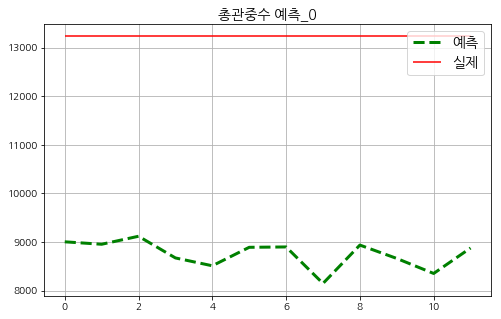

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9050.688, 8998.067, 8928.864, 8671.601, 9180.0625, 8879.491, 8904.614, 8880.574, 9031.268, 8765.798, 8551.741, 8843.364]


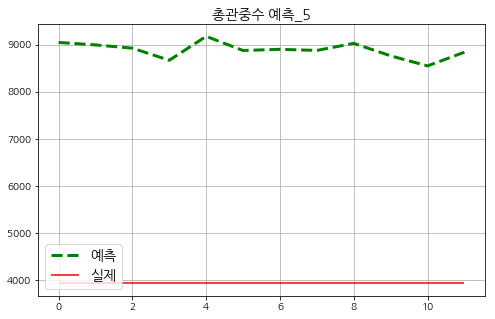

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9018.61, 8994.034, 8869.288, 8763.653, 9005.754, 8883.54, 8884.466, 8738.677, 8951.384, 8755.134, 8412.324, 8792.676]


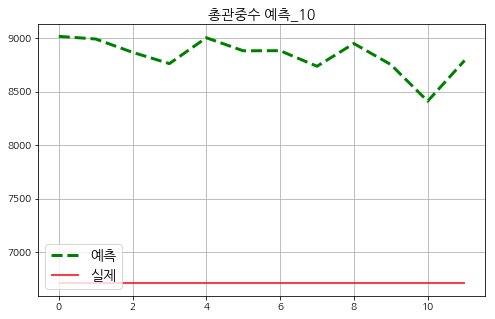

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9086.003, 8953.74, 8389.841, 9016.22, 8667.706, 8886.021, 8878.009, 8670.734, 8945.115, 8589.487, 9312.631, 8498.83]


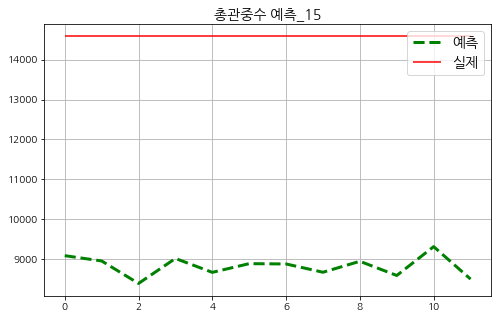

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9037.576, 8947.992, 8844.677, 8749.454, 8984.105, 8906.242, 8897.586, 8812.104, 9053.281, 8867.501, 9150.593, 8836.924]


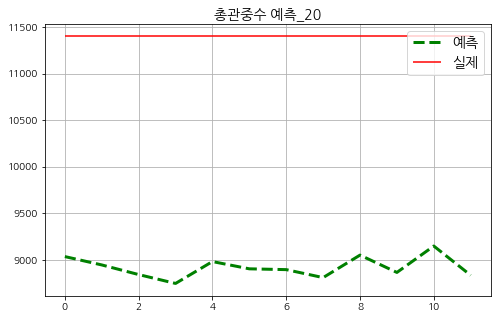

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9047.927, 8956.345, 8898.155, 8253.033, 9771.685, 8878.466, 8942.343, 9383.331, 8880.564, 8120.895, 8854.814, 9078.09]


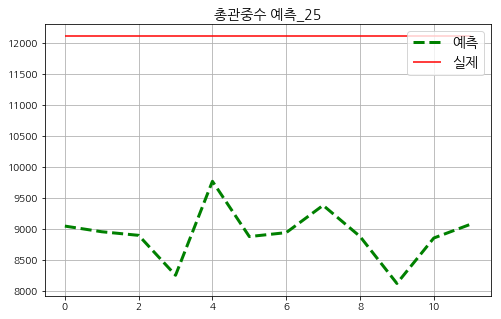

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9049.35, 8981.868, 9090.212, 8998.783, 9082.327, 8903.803, 8892.408, 8845.078, 8966.181, 8766.498, 8724.707, 9410.485]


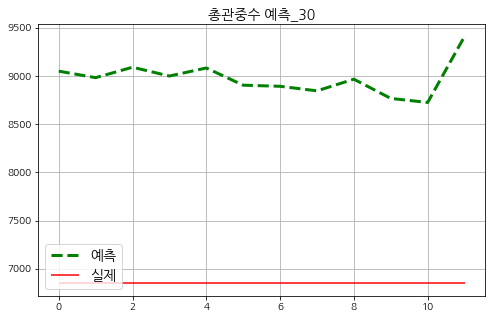

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9077.417, 8957.578, 8939.109, 8778.528, 8726.251, 8899.827, 8901.034, 8838.346, 8897.284, 9076.85, 9040.097, 9312.05]


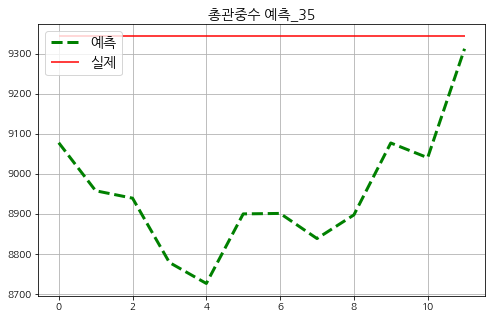

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9026.62, 9018.068, 8824.507, 8928.381, 8987.546, 8909.897, 8907.709, 8933.013, 8924.349, 8878.8955, 8730.046, 8915.343]


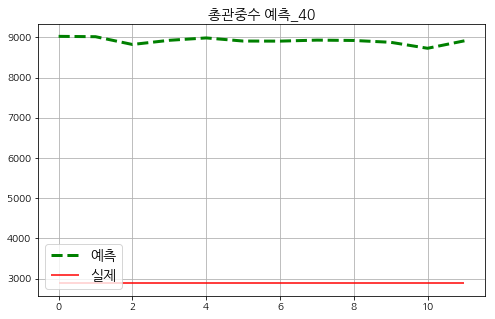

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9030.804, 8987.831, 9036.593, 8468.618, 8558.829, 8864.257, 8866.268, 8535.709, 8933.221, 8633.856, 8912.537, 8442.779]


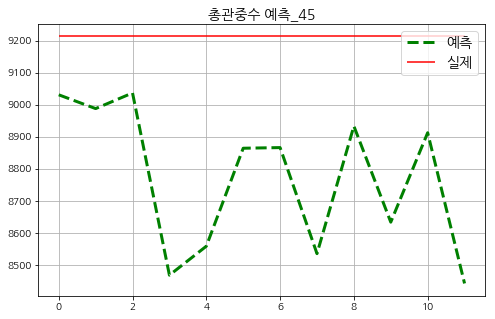

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9086.003, 8948.6045, 9008.778, 8731.434, 8618.727, 8879.298, 8893.471, 8636.582, 8790.528, 8827.964, 8548.095, 9422.665]


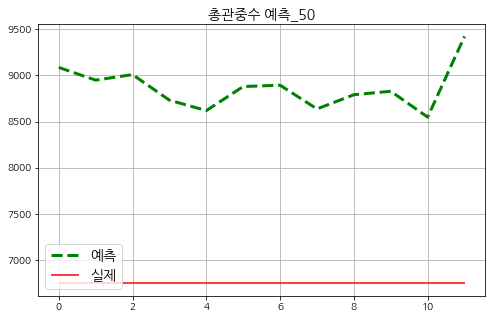

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[8996.725, 8943.403, 9322.858, 8486.903, 8657.544, 8878.852, 8907.195, 8770.41, 8777.924, 8830.767, 8416.267, 9512.158]


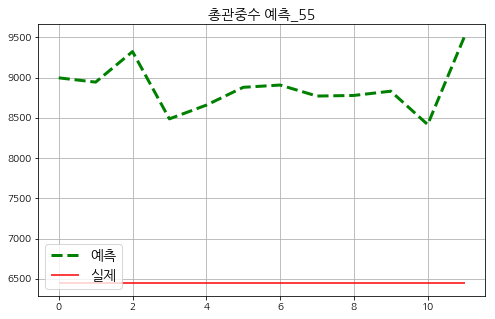

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9007.855, 8951.936, 9098.852, 8429.318, 7939.735, 8859.792, 8891.646, 8083.5127, 8471.044, 8160.496, 8441.973, 9008.846]


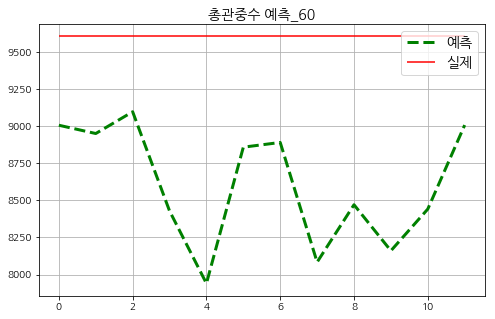

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9058.076, 8969.625, 8894.316, 8801.155, 9781.724, 8923.077, 8923.768, 8786.976, 8792.99, 8646.547, 8657.69, 9831.884]


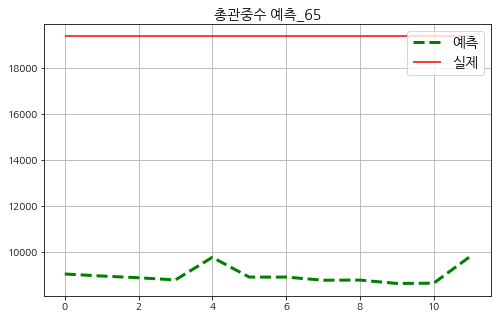

INFO:tensorflow:Restoring parameters from ./models_log/y_model_0
INFO:tensorflow:Restoring parameters from ./models_log/y_model_1
INFO:tensorflow:Restoring parameters from ./models_log/y_model_2
INFO:tensorflow:Restoring parameters from ./models_log/y_model_3
INFO:tensorflow:Restoring parameters from ./models_log/y_model_4
INFO:tensorflow:Restoring parameters from ./models_log/y_model_5
INFO:tensorflow:Restoring parameters from ./models_log/y_model_6
INFO:tensorflow:Restoring parameters from ./models_log/y_model_7
INFO:tensorflow:Restoring parameters from ./models_log/y_model_8
INFO:tensorflow:Restoring parameters from ./models_log/y_model_9
INFO:tensorflow:Restoring parameters from ./models_log/y_model_10
INFO:tensorflow:Restoring parameters from ./models_log/y_model_11
[9027.486, 8976.408, 8937.525, 9078.339, 8860.101, 8902.899, 8890.418, 8864.975, 8892.167, 8992.732, 8566.396, 9028.224]


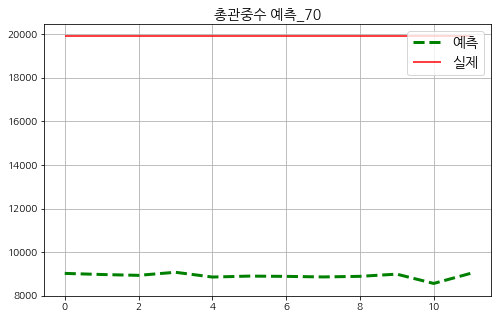

In [16]:
for game_index in range(0, len(y_test), 5) :
    predict_total(X_test, y_test, game_index)    